In [ ]:
import numpy as np

import time
import random
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

#PyTorch modules
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

from torch.optim import SGD,Adam,Adagrad,RMSprop


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


**Ιn the following cell the necessary Python libraries are loaded.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Question 1: Feedforward Neural Network**

**Step 1: Load data (mfccs)**


**Through the following function the data (features in vector X and labels) for the representation of the MFCCs audio signal are loaded, which are stored in Google Drive, using the command np.load(url), where url (main_path) consists of "drive/MyDrive/data/music_genre_data_di/train" for the training set, "drive/MyDrive/data/music_genre_data_di/train" for the validation set, and "drive/MyDrive/data/music_genre_data_di/test" for the test set. (test set) "drive/MyDrive/data/music_genre_data_di/val" and "drive/MyDrive/data/music_genre_data_di/test" and the music signal representation type "mfccs" or "melgrams".**

In [ ]:
def load_data(main_path1, main_path2, main_path3):


  #training set
  x_train = np.load(f"{main_path1}/X.npy")
  y_train = np.load(f"{main_path1}/labels.npy")

  #validation set
  x_val = np.load(f"{main_path2}/X.npy")
  y_val = np.load(f"{main_path2}/labels.npy")

  #mfcc-test set
  x_test = np.load(f"{main_path3}/X.npy")
  y_test = np.load(f"{main_path3}/labels.npy")

  return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
#Load data sample for training, validation and test sets by using as parent directory of the saved data files the
#data/music_genre_data_di/train or data/music_genre_data_di/val or data/music_genre_data_di/test corresponingly
#and as feature path the type of the music file either "mfccs" or "melgrams".

x_train_mfcc,y_train_mfcc,x_val_mfcc,y_val_mfcc,x_test_mfcc,y_test_mfcc = load_data("drive/MyDrive/data/music_genre_data_di/train/mfccs","drive/MyDrive/data/music_genre_data_di/val/mfccs", "drive/MyDrive/data/music_genre_data_di/test/mfccs")

print("x_train_mfcc:", x_train_mfcc.shape)
print("y_train_mfcc:", y_train_mfcc.shape)
print("x_val_mfcc", x_val_mfcc.shape)
print("y_val_mfcc", y_val_mfcc.shape)
print("x_test_mfcc", x_test_mfcc.shape)
print("y_test_mfcc", y_test_mfcc.shape)


x_train_mfcc: (3200, 26)
y_train_mfcc: (3200,)
x_val_mfcc (800, 26)
y_val_mfcc (800,)
x_test_mfcc (1376, 26)
y_test_mfcc (1376,)


**Using the LabelEncoder() class from sklearn's sklearn.preprocessing module, the labels are transformed from strings (classical, blues, etc.) to integers from 0 to 3, keeping the corresponding mapping from the class names to the integers.**

In [ ]:
label_encoder_mfcc = LabelEncoder()
y_train_mfcc_encoded = label_encoder_mfcc.fit_transform(y_train_mfcc)
y_val_mfcc_encoded = label_encoder_mfcc.fit_transform(y_val_mfcc)
y_test_mfcc_encoded = label_encoder_mfcc.fit_transform(y_test_mfcc)

print("y_train_encoded sample: ", y_train_mfcc_encoded)
print("\nlabel mapping: ", label_encoder_mfcc.classes_)
label_map = {i: label for i, label in enumerate(label_encoder_mfcc.classes_)}
print("\nlabel map: ", label_map)

y_train_encoded sample:  [0 0 0 ... 3 3 3]

label mapping:  ['blues' 'classical' 'hiphop' 'rock_metal_hardrock']

label map:  {0: 'blues', 1: 'classical', 2: 'hiphop', 3: 'rock_metal_hardrock'}


###**Question 3: Improving Performance**


**Step 1: Reproducibility (Although this is a question from the exercise below, it is mentioned earlier due to its importance for the entire exercise, especially for loading the dataloader.)**

**The corresponding SEED in Python libraries is set to maintain reproducibility i.e., to ensure that the network will be trained under exactly the same conditions.**

In [ ]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import torch.cuda
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
SEED = 42 # Seed the RNG for all devices (both CPU and CUDA).
rs = RandomState(MT19937(SeedSequence(SEED))) # If any of the libraries or code rely on NumPy seed the global NumPy RNG.



**Also, to ensure reproducibility the following function is created.**

In [ ]:
import torch.backends.cudnn


disable_cudnn =  False
def set_determenistic_mode(disable_cudnn):


 if not disable_cudnn:
    torch.backends.cudnn.benchmark = False    # Causes cuDNN to deterministically select an algorithm,
                                              # possibly at the cost of reduced performance
                                              # (the algorithm itself may be nondeterministic).
    torch.backends.cudnn.deterministic = True # Causes cuDNN to use a deterministic convolution algorithm,
                                              # but may slow down performance.
                                              # It will not guarantee that your training process is deterministic
                                              # if you are using other libraries that may use nondeterministic algorithms
 else:
    torch.backends.cudnn.enabled = False # Controls whether cuDNN is enabled or not.
                                         # If you want to enable cuDNN, set it to True.


**Below, the data is loaded into 3 Pytorch dataloader objects (one for each dataset (training, inspection, and testing)) with a batch size of 16, so that they can be used in the respective models. The argument shuffle=True is also given to the train and validation dataloaders. The corresponding datasets for loading into the dataloaders are created using the torch.from_numpy() command to convert a numpy array to a PyTorch tensor, and the Pytorch TensorDataset object. Each Dataset object has the following structure: (features, labels).**

**Also, the set_epoch function helps to shuffle differently but in the same reproducible way each epoch, the generator must be reset by creating a snapshot (self.g) of the torch. Generator in the torch.utils.data.DataLoader class to maintain reproducibility. In addition, a corresponding SEED is set in Python libraries, as well as in number generators to maintain reproducibility. For more details on what was created to maintain reproducibility: https://darinabal.medium.com/deep-learning-reproducible-results-using-pytorch-42034da5ad7.**

In [ ]:
#Train TensorDataset, DataLoader
train_dataset_mfcc = TensorDataset(torch.from_numpy(x_train_mfcc), torch.from_numpy(y_train_mfcc_encoded))

train_dataloader_mfcc = DataLoader(train_dataset_mfcc, batch_size=16, shuffle=True ,num_workers=0,
    worker_init_fn=seed_worker)


#Validation TensorDataset, DataLoader
val_dataset_mfcc = TensorDataset(torch.from_numpy(x_val_mfcc), torch.from_numpy(y_val_mfcc_encoded))

val_dataloader_mfcc = DataLoader(val_dataset_mfcc, batch_size=16, shuffle=True ,num_workers=0,
    worker_init_fn=seed_worker)

#Test TensorDataset, DataLoader
test_dataset_mfcc = TensorDataset(torch.from_numpy(x_test_mfcc), torch.from_numpy(y_test_mfcc_encoded))

test_dataloader_mfcc = DataLoader(test_dataset_mfcc, batch_size=16, shuffle=False ,num_workers=0,
    worker_init_fn=seed_worker)


**Step 2: Defining a Neural Network**



**Definition of a fully connected neural network class consisting of 4 layers with 26, 128, 32, and 4 neurons, respectively, where 26 is the input dimension and 4 is the number of classes to be predicted.**

In [ ]:
class FeedforwardNN(nn.Module):
  def __init__(self, D_in: int, hiddenSizes: list, D_out: int):
    super(FeedforwardNN, self).__init__()
    self.dense1 = nn.Linear(D_in, hiddenSizes[0])
    self.dense2 = nn.Linear(hiddenSizes[0], hiddenSizes[1])
    self.dense3 = nn.Linear(hiddenSizes[1], hiddenSizes[0])
    self.dense4 = nn.Linear(hiddenSizes[0], D_out)

  def forward(self, x):
      x = self.dense1(x)

      x = self.dense2(x)

      x = self.dense3(x)

      x = self.dense4(x)
      return x

**Step 3: Define training and evaluation procedures**


**The training and evaluation functions are created. More specifically, the training function accepts as parameters a number of epochs, an optimizer, a dataloader for both the training set and the test set, a loss function and a neural network, passes each batch of the dataloader through the neural network, calculates and prints the loss, and finally updates the weights, while terminating by returning the neural network when the number of epochs is reached.**

In [ ]:
#Training and validation function
def train_function(epochs, dataloader, optimizer, loss_function, model, scheduler, model_dir, model_save_name, validation_dataloader):
  epoch_best_model = 0
  max_f1 = -1
  list_loss_val = []
  list_loss_train = []
  list_epochs = []
  the_last_f1_score = 0
  patience = 6
  trigger_times = 0
  if not os.path.exists(model_dir):
     os.makedirs(model_dir)
  model_save_path = os.path.join(model_dir, model_save_name)
  start_time =  time.time()
  for epoch in range(epochs):
    batch_losses = []
    #Train
    model.train()
    for x, y in dataloader:
      x = x.to(device)
      y = y.to(device)
      y_pred = model(x)
      loss = loss_function(y_pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batch_losses.append(loss.item())
    scheduler.step()
    print(f"Epoch {epoch:3}: Train Loss = {sum(batch_losses)/len(dataloader):.5f}")
    list_loss_train.append(sum(batch_losses)/len(dataloader))
    batch_losses_val = []
    Y_batches = []
    Y_Preds = []
    with torch.no_grad():
        model.eval()
        for x, y in validation_dataloader:
          x = x.to(device)
          y = y.to(device)
          y_predict = model(x)

          val_loss = loss_function(y_predict, y)
          batch_losses_val.append(val_loss.item())
          Y = y.tolist()
          Y_preds = y_predict.tolist()
          Y_batches.append(Y)
          Y_Preds.append(Y_preds)
        Y_batches = np.concatenate(Y_batches)
        Y_Preds = np.concatenate(Y_Preds)
        Y_Preds = np.argmax(Y_Preds, axis = 1) #take the index of the maximum value
        Valid_f1 = f1_score(Y_batches, Y_Preds, average='macro')#f1_macro for 1 epoch on the whole validation sample.
        Valid_accuracy = accuracy_score(Y_batches, Y_Preds)#accuracy score for 1 epoch on the whole validation sample.
        Valid_loss = sum(batch_losses_val)/len(validation_dataloader) #average loss value for 1 epoch on the whole validation sample.
        list_loss_val.append(Valid_loss)
        list_epochs.append(epoch)
        print(f"Epoch {epoch:3}: Valid Loss = {Valid_loss:.5f}")
        print(f"Epoch {epoch:3}: Valid f1_score = {Valid_f1:.5f}")
        print(f"Epoch {epoch:3}: Valid Acurracy = {Valid_accuracy:.5f}")
        if Valid_f1 > max_f1:
          max_f1 = Valid_f1
          torch.save(model.state_dict(), model_save_path)
          epoch_best_model = epoch
        print('The current f1 score:', Valid_f1)
        if Valid_f1 < the_last_f1_score:
            trigger_times += 1
            print('trigger times:', trigger_times)
            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break;
        the_last_f1_score = Valid_f1
  plt.figure(figsize=(8,8))
  plt.plot(list_epochs, list_loss_val)
  plt.plot(list_epochs, list_loss_train)
  plt.ylim(ymin = 0)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(["Validation", "Training"])
  plt.title("loss learning curve")
  end_time = time.time()
  print("done in % 0.3fs" % (end_time - start_time))
  print(f"Total time model running for {epochs} epochs on {device}")
  print(f"\nBest model saved on epoch: {epoch_best_model+1}")


  return model


**Βήμα 4: Ορισμός διαδικασίας διαδικασίας αξιολόγησης**

**Below, the evaluation function is created, accepting as parameters the dataloader of each test set, the final model resulting from the training function, the loss function, which will pass all batches of a dataloader through the model, taking its predictions without updating the weights. Through the predictions, it will calculate and return (i) the loss, (ii) the f1 macro averaged, (iii) the accuracy, and (iv) the confusion matrix.**

**The evaluation functions also accept the following parameters as arguments: 1) model_dir, which refers to the folder that stores the state of the neural network, and 2) model_save_name, which is the name of the folder that stores the weights of the model.**

**To keep the best snapshot of each model and use it in the evaluation function, it is first saved with torch.save(best_model.state_dict(), model_save_path = os.path.join(model_dir,model_save_name), where model is the object corresponding to the model and model_save_path corresponds to the path that will save the parameters corresponding to the best possible model. Then the best model is loaded using the command model.load_state_dict(torch.load(os.path.join(model_save_path))).**

In [ ]:
#Test function
def test_function(dataloader,final_model, model_dir, model_save_name, loss_function):

    if not os.path.exists(model_dir):
     os.makedirs(model_dir)
    model_save_path = os.path.join(model_dir, model_save_name)
    final_model.load_state_dict(torch.load(model_save_path))
    final_model.eval()
    batch_losses_test = []
    Y_batches = []
    Y_Preds = []
    with torch.no_grad():

        for x, y in dataloader:
          x = x.to(device)
          y = y.to(device)
          y_predict = final_model(x)

          val_loss = loss_function(y_predict, y)
          batch_losses_test.append(val_loss.item())
          Y = y.tolist()
          Y_preds = y_predict.tolist()
          Y_batches.append(Y)
          Y_Preds.append(Y_preds)
        Y_batches = np.concatenate(Y_batches)
        Y_Preds = np.concatenate(Y_Preds)
        Y_Preds = np.argmax(Y_Preds, axis = 1)
        Test_f1 = f1_score(Y_batches, Y_Preds, average='macro')
        Test_accuracy = accuracy_score(Y_batches, Y_Preds)
        Test_loss = sum(batch_losses_test)/len(dataloader)
        print(f"Valid Loss = {Test_loss:.5f}")
        print(f"Valid f1_score = {Test_f1:.5f}")
        print(f"Valid Acurracy = {Test_accuracy:.5f}")

    cm = confusion_matrix(np.asarray(Y_batches), np.asarray(Y_Preds)) #confusion matrix
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['blues', 'classical', 'hiphop', 'rock_metal_hardrock'])
    cm_disp.plot()
    plt.show()

    return Test_loss,Test_f1,Test_accuracy, confusion_matrix

**Step 5: Network training**


**As shown below, another practical way to ensure reproducibility is to use the set_seed(SEED) function before initializing each neural network.**

In [ ]:
def set_seed(SEED):
 random.seed(SEED)# Set python seed for custom operators.
 torch.manual_seed(SEED)
 np.random.seed(SEED)
 torch.cuda.manual_seed_all(SEED)
 set_determenistic_mode(disable_cudnn)

In [ ]:
loss_function = nn.CrossEntropyLoss()
set_seed(SEED)
model = FeedforwardNN(x_train_mfcc.shape[1], [128,32], 4).to(device)
print(model)
#Change model.weights to the same type of training features.
target_dtype = torch.float64
for param in model.parameters():
  param.data = param.data.to(target_dtype)
#Initialized optimizer object
optimizer = SGD(model.parameters(), lr=2e-3)

FeedforwardNN(
  (dense1): Linear(in_features=26, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=32, bias=True)
  (dense3): Linear(in_features=32, out_features=128, bias=True)
  (dense4): Linear(in_features=128, out_features=4, bias=True)
)


**The training of the above neural network (FNN) in the training set is performed using stochastic gradient descent (SGD) as the optimizer, a learning rate equal to 0.002, cross-entropy loss as the loss function, and a number of epochs equal to 30.**

**Steps 6 and 7: Network training with GPU and model selection**

Epoch   0: Train Loss = 1.38965
Epoch   0: Valid Loss = 1.37893
Epoch   0: Valid f1_score = 0.10769
Epoch   0: Valid Acurracy = 0.24625
Epoch   1: Train Loss = 1.37319
Epoch   1: Valid Loss = 1.36315
Epoch   1: Valid f1_score = 0.17662
Epoch   1: Valid Acurracy = 0.28250
Epoch   2: Train Loss = 1.35971
Epoch   2: Valid Loss = 1.34891
Epoch   2: Valid f1_score = 0.27705
Epoch   2: Valid Acurracy = 0.39125
Epoch   3: Train Loss = 1.34177
Epoch   3: Valid Loss = 1.34485
Epoch   3: Valid f1_score = 0.19914
Epoch   3: Valid Acurracy = 0.30375
Epoch   4: Train Loss = 1.32109
Epoch   4: Valid Loss = 1.30892
Epoch   4: Valid f1_score = 0.44881
Epoch   4: Valid Acurracy = 0.52000
Epoch   5: Train Loss = 1.29979
Epoch   5: Valid Loss = 1.28285
Epoch   5: Valid f1_score = 0.37447
Epoch   5: Valid Acurracy = 0.44125
Epoch   6: Train Loss = 1.27187
Epoch   6: Valid Loss = 1.24910
Epoch   6: Valid f1_score = 0.56583
Epoch   6: Valid Acurracy = 0.57250
Epoch   7: Train Loss = 1.24041
Epoch   7: Valid

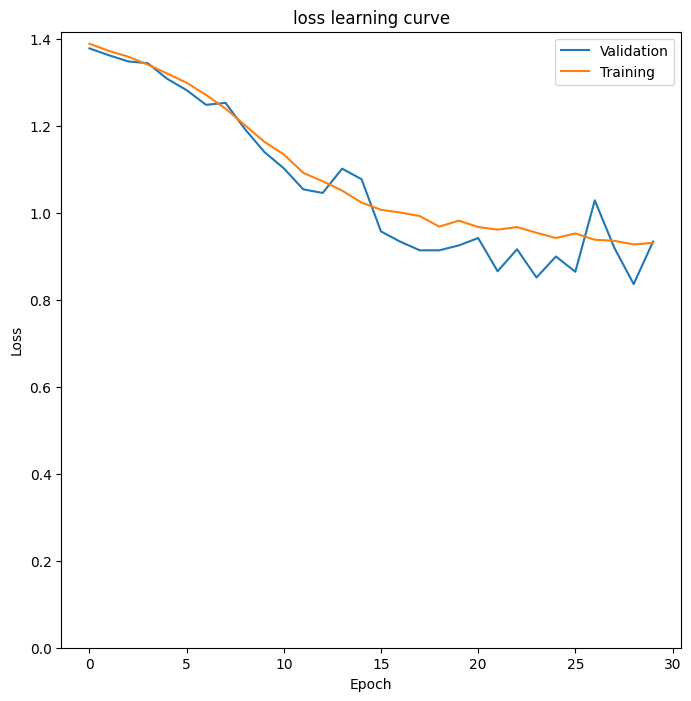

In [ ]:
fnn = train_function(30, train_dataloader_mfcc, optimizer, loss_function, model, "drive/MyDrive/data/music_genre_data_di/","FNN.pt" , val_dataloader_mfcc)

Valid Loss = 0.94093
Valid f1_score = 0.61945
Valid Acurracy = 0.62863


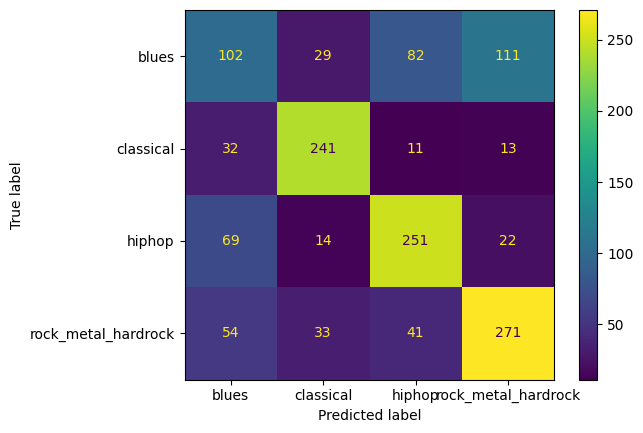

In [ ]:
set_seed(SEED)
model = FeedforwardNN(x_train_mfcc.shape[1], [128,32], 4).to(device)
test_loss, test_f1, test_accuracy, confusion_matrix = test_function(test_dataloader_mfcc, fnn , "drive/MyDrive/data/music_genre_data_di/","FNN.pt", loss_function)

**Essentially, for each model, through the training function, we obtain the best snapshot at the time when the value of the f1 metric is the highest. Based on this snapshot and the evaluation function, we obtain the performance for the test set. This will apply to the rest of the exercise.**

**The above model does not produce good predictions. From the confusion matrix, the music categories with the highest percentage of correct predictions are "classical" with 241 out of 297 samples, i.e. 81.14%, and "hip-hop" with 271 out of 356 (70.5%), with fewer misclassifications, while the other two music categories have several misclassifications in other music genres, especially "blues," which also has the fewest correct classifications in its genre (true positives), with a 33% rate of correct predictions.  In conclusion, the training and inspection sets did not achieve an accurate separation between all music categories to a significant degree.**


**Also, running the entire training and evaluation process on both CPU and GPU the time difference ΔT = |tCPU-tGPU| = |(8.772-13.378)seconds|= 4.606 seconds, which is a particularly small difference in time for this neural network and the seasons for which we run it.**

**In the cell below the data (features in vector X and labels) for the representation of the mel-grams audio signal are loaded, which consists essentially a spectrogram to which the mel scale is applied. The data loading process is the same, with the only difference being that "melgrams" is used as the music class (or feature) type.**

**Also, in the following two cells, the same procedure is followed for mapping labels to integers, but also for loading data into dataloaders.**

###**Question 2: Convolutional Neural Network**

**Step 1: Load data(spectrograms)**

In [ ]:
#training set
x_train_mel, y_train_mel, x_val_mel, y_val_mel, x_test_mel, y_test_mel = load_data("drive/MyDrive/data/music_genre_data_di/train/melgrams","drive/MyDrive/data/music_genre_data_di/val/melgrams","drive/MyDrive/data/music_genre_data_di/test/melgrams")

print("x_train:", x_train_mel.shape)
print("y_train:", y_train_mel.shape)
print("x_val", x_val_mel.shape)
print("y_val", y_val_mel.shape)
print("x_test", x_test_mel.shape)
print("y_test", x_test_mel.shape)

x_train: (3200, 21, 128)
y_train: (3200,)
x_val (800, 21, 128)
y_val (800,)
x_test (1376, 21, 128)
y_test (1376, 21, 128)


In [ ]:
label_encoder_mel = LabelEncoder()
y_train_mel_encoded = label_encoder_mel.fit_transform(y_train_mel)
y_val_mel_encoded = label_encoder_mel.fit_transform(y_val_mel)
y_test_mel_encoded = label_encoder_mel.fit_transform(y_test_mel)

print("y_train_encoded sample: ", y_train_mel_encoded)
print("\nlabel mapping: ", label_encoder_mel.classes_)
label_map = {i: label for i, label in enumerate(label_encoder_mel.classes_)}
print("\nlabel map: ", label_map)

y_train_encoded sample:  [0 0 0 ... 3 3 3]

label mapping:  ['blues' 'classical' 'hiphop' 'rock_metal_hardrock']

label map:  {0: 'blues', 1: 'classical', 2: 'hiphop', 3: 'rock_metal_hardrock'}


In [ ]:
#Train TensorDataset, DataLoader
training_data_mel = TensorDataset(torch.from_numpy(x_train_mel), torch.from_numpy(y_train_mel_encoded))

train_dataloader_mel = DataLoader(training_data_mel, batch_size=16, shuffle=True ,num_workers=0,
    worker_init_fn=seed_worker)

#Validation TensorDataset, DataLoader
validation_data_mel = TensorDataset(torch.from_numpy(x_val_mel), torch.from_numpy(y_val_mel_encoded))

validation_dataloader_mel = DataLoader(validation_data_mel, batch_size=16, shuffle=True ,num_workers=0,
    worker_init_fn=seed_worker)

#Test TensorDataset, DataLoader
test_data_mel = TensorDataset(torch.from_numpy(x_test_mel), torch.from_numpy(y_test_mel_encoded))

test_dataloader_mel = DataLoader(test_data_mel, batch_size=16, shuffle=False ,num_workers=0,
    worker_init_fn=seed_worker)



**Through the function count_labels the number of items in each music category (blues, classical, hip hop, rock, metal, hard rock) is measured in each of the training, inspection, and control sets, so that we know exactly how many items from each music category are in each set. For each music genre, there is the same number in each of the training, inspection, and control sets for both melgrams and mfccs.**

In [ ]:
#Count how much labels there are from each music category in training validation and test data for melgrams and mfccs.
def count_labels(dataset_mel):
 c0 = 0
 c1 = 0
 c2 = 0
 c3 = 0
 for k in range(len(dataset_mel)):
   if dataset_mel[k][1] == torch.tensor(0.):
      c0 += 1
   elif dataset_mel[k][1] == torch.tensor(1.):
      c1 += 1
   elif dataset_mel[k][1] == torch.tensor(2.):
      c2 += 1
   else:
      c3 += 1
 return c0,c1,c2,c3

**With the help of the function named plot_music_classes, a random melgram from each music class (blues, classical, hip hop, rock, metal, hard rock) from the training set is visualized.**

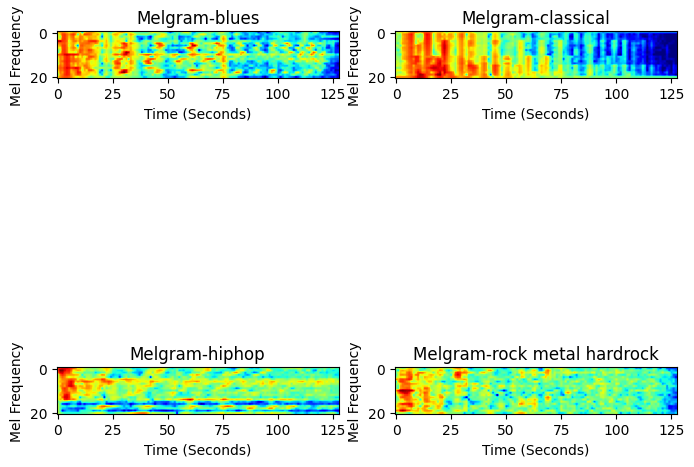

In [ ]:
#Plotting a random melgram for each music category from the training set
def plot_music_classes(c0,c1,c2,c3,data_mel):
 sample_idx = []
 plt.subplots(2,2,figsize = (8,8))
 sample_idx_blues = torch.randint(1,c0, size=(1,)).item()
 sample_idx_classical = torch.randint((c0),(c0+c1), size=(1,)).item()
 sample_idx_hiphop = torch.randint((c0+c1),(c0+c1+c2), size=(1,)).item()
 sample_idx_rockmetal = torch.randint((c0+c1+c2),(c0+c1+c2+c3), size=(1,)).item()
 sample_idx.append(sample_idx_blues)
 sample_idx.append(sample_idx_classical)
 sample_idx.append(sample_idx_hiphop)
 sample_idx.append(sample_idx_rockmetal)
 rows, columns = 2,2
 for i in range(1, rows*columns+1):
  img, label = data_mel[sample_idx[i-1]]
  plt.subplot(rows, columns, i)
  plt.imshow(img.squeeze(), cmap="jet")
  if label == torch.tensor(0.):
      plt.title('Melgram-blues')
  elif label == torch.tensor(1.):
      plt.title('Melgram-classical')
  elif label == torch.tensor(2.):
      plt.title('Melgram-hiphop')
  else:
      plt.title('Melgram-rock metal hardrock')

  plt.xlabel("Time (Seconds)")
  plt.ylabel("Mel Frequency")
 plt.show()
train_0_mel,train_1_mel,train_2_mel,train_3_mel = count_labels(training_data_mel)
val_0_mfcc,val_1_mfcc,val_2_mfcc,val_3_mel = count_labels(validation_data_mel)
test_0_mel,test_1_mel,test_2_mel,test_3_mel = count_labels(test_data_mel)
plot_music_classes(train_0_mel,train_1_mel,train_2_mel,train_3_mel,training_data_mel)

**Βήμα 2: Ορισμός Νευρωνικού Δικτύου**

**Defining of a Convolutional Neural Network consisting of a sequence of four convolutional layers, with a kernel size of 5, to achieve the following channel sequence: 1, 16, 32, 64, 128, so that the output of the last convolutional layer enters a fully connected 5-layer neural network with the following number of neurons: x (convolutional network output dimension), 1024, 256, 32, out_dim which is equal to 4.**

**Below we will see 2 cases of neural networks, one without pooling and padding in the convolutional networks and one with their implementation.**

In [ ]:
class ConvolutionalNet(nn.Module):
  def __init__(self):
    super().__init__()
    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.conv3 = nn.Conv2d(32, 64, 5)
    self.conv4 = nn.Conv2d(64, 128, 5)
    self.flat = nn.Flatten()
    self.dense1 = nn.Linear(71680, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 256)
    self.dense4 = nn.Linear(256, 32)
    self.dense5 = nn.Linear(32, 4)


  def forward(self, x):
    x = x.unsqueeze(1)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.flat(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    x = self.dense4(x)
    x = self.dense5(x)
    return x

In [ ]:
set_seed(SEED)
model_conv = ConvolutionalNet().to(device)
print(model_conv)
#Change model.weights to the same type of training features.
#target_dtype = torch.float64
#for param in model.parameters():
  #param.data = param.data.to(target_dtype)
#Initialized optimizer object
opt1= SGD(model_conv.parameters(), lr=2e-3)


ConvolutionalNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=71680, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=256, bias=True)
  (dense4): Linear(in_features=256, out_features=32, bias=True)
  (dense5): Linear(in_features=32, out_features=4, bias=True)
)


**Step 3: Network training**

Epoch   0: Train Loss = 1.44568
Epoch   0: Valid Loss = 1.21227
Epoch   0: Valid f1_score = 0.48608
Epoch   0: Valid Acurracy = 0.49500
Epoch   1: Train Loss = 1.43654
Epoch   1: Valid Loss = 1.19993
Epoch   1: Valid f1_score = 0.48956
Epoch   1: Valid Acurracy = 0.49750
Epoch   2: Train Loss = 1.31213
Epoch   2: Valid Loss = 1.20297
Epoch   2: Valid f1_score = 0.43835
Epoch   2: Valid Acurracy = 0.49875
Epoch   3: Train Loss = 1.00322
Epoch   3: Valid Loss = 0.96961
Epoch   3: Valid f1_score = 0.60015
Epoch   3: Valid Acurracy = 0.60250
Epoch   4: Train Loss = 0.87170
Epoch   4: Valid Loss = 0.91341
Epoch   4: Valid f1_score = 0.62830
Epoch   4: Valid Acurracy = 0.63000
Epoch   5: Train Loss = 0.81084
Epoch   5: Valid Loss = 0.95474
Epoch   5: Valid f1_score = 0.60368
Epoch   5: Valid Acurracy = 0.61250
Epoch   6: Train Loss = 0.76276
Epoch   6: Valid Loss = 0.96567
Epoch   6: Valid f1_score = 0.60617
Epoch   6: Valid Acurracy = 0.60875
Epoch   7: Train Loss = 0.73066
Epoch   7: Valid

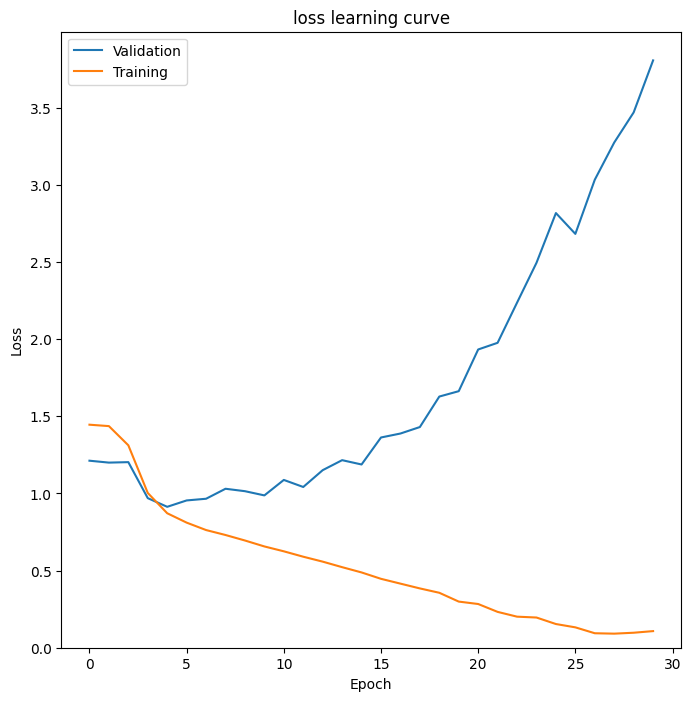

In [ ]:
cnn = train_function(30, train_dataloader_mel, opt1, loss_function, model_conv,"drive/MyDrive/data/music_genre_data_di/","Convolutional_SGD.pt" ,validation_dataloader_mel)

Valid Loss = 1.11037
Valid f1_score = 0.52948
Valid Acurracy = 0.52834


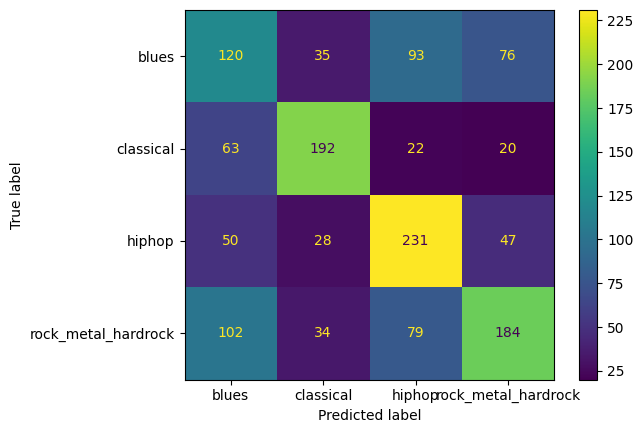

In [ ]:
#set_seed(SEED)
#cnn = ConvolutionalNet().to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn ,"drive/MyDrive/data/music_genre_data_di/","Convolutional_SGD.pt", loss_function)

In [ ]:
print(sum(p.numel() for p in model_conv.parameters() if p.requires_grad))

74007332


**We note that this network is not trained because for this convolutional neural network, its last layer produces an output of dimensions [128,5,112], where 128 * 5 * 112 = 71680, and this will be the input to the fully connected neural network that follows the convolutional network. This will give us a very large number of trainable parameters, equal to 74,007,332, and therefore a large neural network, which is not at all desirable or acceptable, mainly in terms of the time required for training.**

**Furthermore, the results show that the f1 and accuracy values in the inspection set are low (not above 60%), but also that the difference between train loss and validation loss is constantly increasing due to the increase in validation loss. From the test set, the results show that the f1 and accuracy values are significantly lower than the corresponding values of the best snapshot from the training set, so they are not representative of the best snapshot resulting from the model training process, meaning that the model has not been trained.**

**Βήμα 4: Pooling and padding**


**To solve the above problem of too many parameters, padding and pooling elements are used in the above convolutional layer.**

**A pooling layer is used to downsample the feature maps resulting from the convolutional layers. This reduces the spatial dimensions (height and width), in this case through maxpooling, where we take the maximum from each feature map. This achieves the union, compression, and generalization of the features learned from the convolutional layers.**

**Padding in a convolutional layer is used as follows: The reduction of the input size to the size of the feature map is due to the interaction of the FXF filter with the boundary of the input image. To address this, we add pixels with a value of 0 to each side of the input feature map, e.g., 2 lines beyond the size of the feature map frame resulting after applying each convolutional layer (if, for example, padding = 2).**

**Padding, i.e., adding pixels to the edges of each image, ensures that the spatial dimensions of the input feature maps will be the same as those of the original input after maxpooling with a kernel size of 2.**


In [ ]:
class ConvolutionalNet_with_pooling_padding(nn.Module):
  def __init__(self,activation):
    super(ConvolutionalNet_with_pooling_padding, self).__init__()
    # in channels, out_channels, kernel_size

    self.conv1 = nn.Conv2d(1, 16, 5, padding = 2)
    #self.batch_norm1 = nn.BatchNorm2d(num_features = 16)
    self.conv2 = nn.Conv2d(16, 32, 5 , padding = 2)
    #self.batch_norm2 = nn.BatchNorm2d(num_features = 32)
    self.conv3 = nn.Conv2d(32, 64, 5 , padding = 2)
    #self.batch_norm3 = nn.BatchNorm2d(num_features = 64)
    self.conv4 = nn.Conv2d(64, 128, 5 , padding = 2)
    #self.batch_norm4 = nn.BatchNorm2d(num_features = 128)
    self.max_pool = nn.MaxPool2d(2)
    self.flat = nn.Flatten()
    #self.dropout_probability = dropout_probability
    self.dense1 = nn.Linear(128*2*4, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 32)
    self.dense5 = nn.Linear(32, 4)
    self.activation = activation
    #self.dropout = nn.Dropout(self.dropout_probability)

  def forward(self, x):
    #x = self.dropout(self.dense1(self.activation(x)))
    #x = self.dropout(self.dense2(self.activation(x)))
    #x = self.dropout(self.dense3(self.activation(x)))
    #x = self.dropout(self.dense4(self.activation(x)))
    x = x.unsqueeze(1)
    x = self.max_pool(self.activation(self.conv1(x)))
    x = self.max_pool(self.activation(self.conv2(x)))
    x = self.max_pool(self.activation(self.conv3(x)))
    x = self.max_pool(self.activation(self.conv4(x)))
    x = self.flat(x)
    x = self.dense1(self.activation(x))
    x = self.dense2(self.activation(x))
    x = self.dense3(self.activation(x))
    x = self.dense4(self.activation(x))
    x = self.dense5(x)


    return x

In [ ]:
loss_function = nn.CrossEntropyLoss()

In [ ]:
set_seed(SEED)
model_conv_pooling_padding = ConvolutionalNet_with_pooling_padding().to(device)
print(model_conv_pooling_padding)
#Change model.weights to the same type of training features.
#target_dtype = torch.float64
#for param in model_conv_pooling_padding.parameters():
  #param.data = param.data.to(target_dtype)
#Initialized optimizer object
opt2 = SGD(model_conv_pooling_padding.parameters(), lr=2e-3)

ConvolutionalNet_with_pooling_padding(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=32, bias=True)
  (dense5): Linear(in_features=32, out_features=4, bias=True)
)


In [ ]:
print(sum(p.numel() for p in model_conv_pooling_padding.parameters() if p.requires_grad))

1590852


**Pooling and padding reduce the number of trainable parameters from 74,007,332 to 1,590,852, which is particularly helpful for better network training.**

**Step 5: Optimization algorithms**

Epoch   0: Train Loss = 1.34611
Epoch   0: Valid Loss = 1.30749
Epoch   0: Valid f1_score = 0.29708
Epoch   0: Valid Acurracy = 0.42625
Epoch   1: Train Loss = 1.21102
Epoch   1: Valid Loss = 1.41584
Epoch   1: Valid f1_score = 0.19130
Epoch   1: Valid Acurracy = 0.30625
Epoch   2: Train Loss = 1.08627
Epoch   2: Valid Loss = 1.04658
Epoch   2: Valid f1_score = 0.51621
Epoch   2: Valid Acurracy = 0.53750
Epoch   3: Train Loss = 1.00113
Epoch   3: Valid Loss = 0.97589
Epoch   3: Valid f1_score = 0.50459
Epoch   3: Valid Acurracy = 0.54875
Epoch   4: Train Loss = 0.92685
Epoch   4: Valid Loss = 1.00167
Epoch   4: Valid f1_score = 0.55248
Epoch   4: Valid Acurracy = 0.56750
Epoch   5: Train Loss = 0.87729
Epoch   5: Valid Loss = 0.90032
Epoch   5: Valid f1_score = 0.60144
Epoch   5: Valid Acurracy = 0.59500
Epoch   6: Train Loss = 0.82403
Epoch   6: Valid Loss = 0.95702
Epoch   6: Valid f1_score = 0.55305
Epoch   6: Valid Acurracy = 0.58500
Epoch   7: Train Loss = 0.80044
Epoch   7: Valid

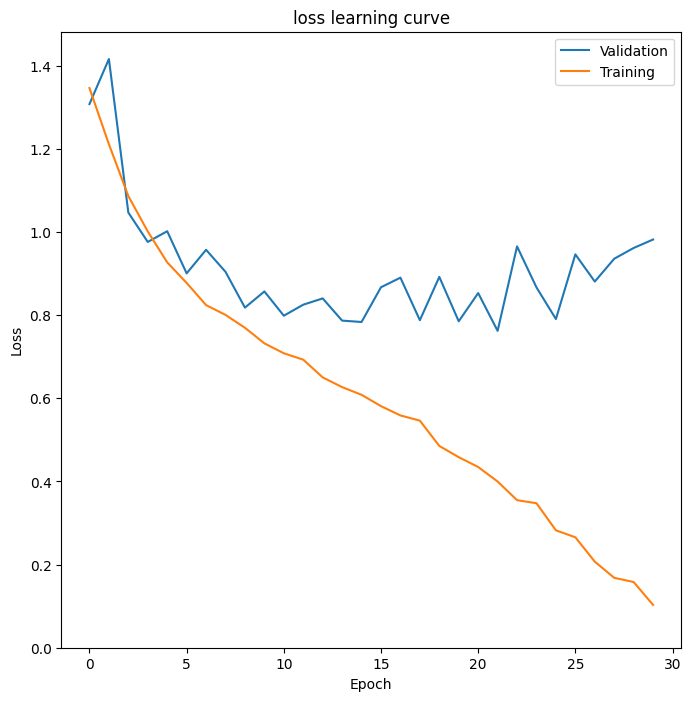

In [ ]:
cnn_pooling_padding = train_function(30, train_dataloader_mel, opt2, loss_function, model_conv_pooling_padding, "drive/MyDrive/data/music_genre_data_di/", "Best_Model.pt" , validation_dataloader_mel)

Valid Loss = 0.93750
Valid f1_score = 0.69617
Valid Acurracy = 0.69113


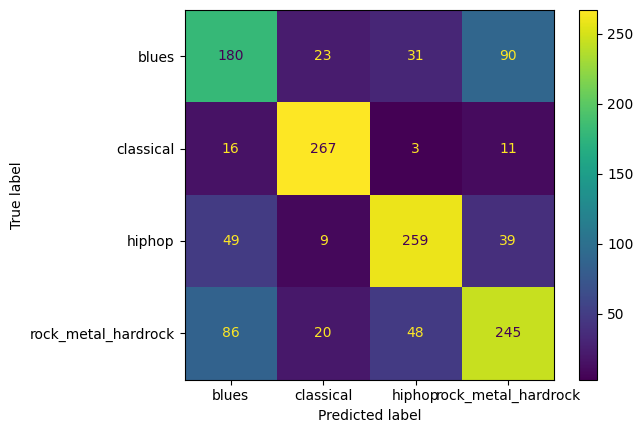

In [ ]:
#set_seed(SEED)
#cnn_pooling_padding = ConvolutionalNet_with_pooling_padding().to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding, "drive/MyDrive/data/music_genre_data_di/", "Best_Model.pt"  ,loss_function)

In [ ]:
set_seed(SEED)
model_conv_pooling_padding = ConvolutionalNet_with_pooling_padding().to(device)
opt3 = Adam(model_conv_pooling_padding.parameters(), lr=2e-3)

Epoch   0: Train Loss = 4.66912
Epoch   0: Valid Loss = 1.05248
Epoch   0: Valid f1_score = 0.44415
Epoch   0: Valid Acurracy = 0.47875
Epoch   1: Train Loss = 0.97482
Epoch   1: Valid Loss = 0.96881
Epoch   1: Valid f1_score = 0.60849
Epoch   1: Valid Acurracy = 0.64500
Epoch   2: Train Loss = 0.78973
Epoch   2: Valid Loss = 0.75192
Epoch   2: Valid f1_score = 0.66075
Epoch   2: Valid Acurracy = 0.67875
Epoch   3: Train Loss = 0.70482
Epoch   3: Valid Loss = 0.72963
Epoch   3: Valid f1_score = 0.70095
Epoch   3: Valid Acurracy = 0.70250
Epoch   4: Train Loss = 0.58399
Epoch   4: Valid Loss = 0.68043
Epoch   4: Valid f1_score = 0.75076
Epoch   4: Valid Acurracy = 0.75500
Epoch   5: Train Loss = 0.55142
Epoch   5: Valid Loss = 0.77980
Epoch   5: Valid f1_score = 0.71061
Epoch   5: Valid Acurracy = 0.70500
Epoch   6: Train Loss = 0.45774
Epoch   6: Valid Loss = 0.83583
Epoch   6: Valid f1_score = 0.67747
Epoch   6: Valid Acurracy = 0.69875
Epoch   7: Train Loss = 0.37352
Epoch   7: Valid

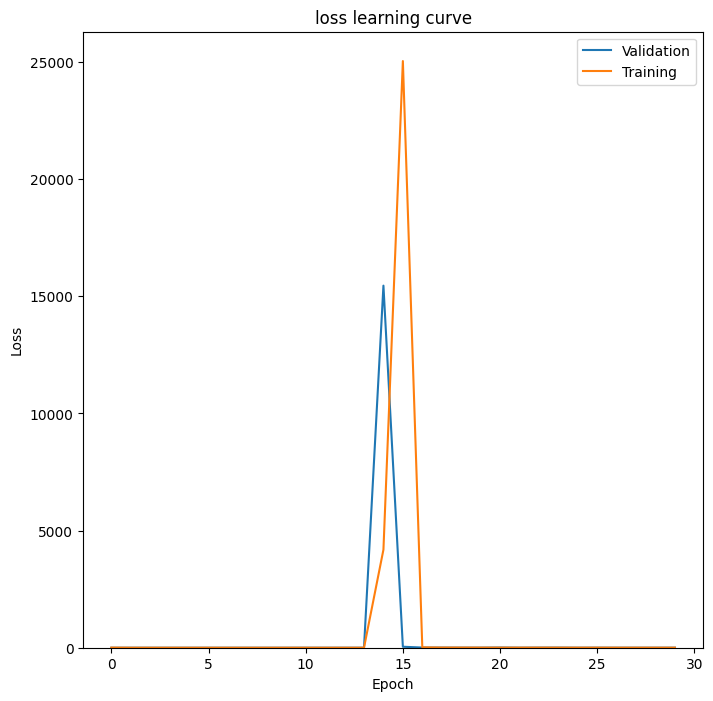

In [ ]:
cnn_pooling_padding = train_function(30, train_dataloader_mel, opt3, loss_function, model_conv_pooling_padding, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt", validation_dataloader_mel)

Valid Loss = 0.68256
Valid f1_score = 0.74750
Valid Acurracy = 0.74709


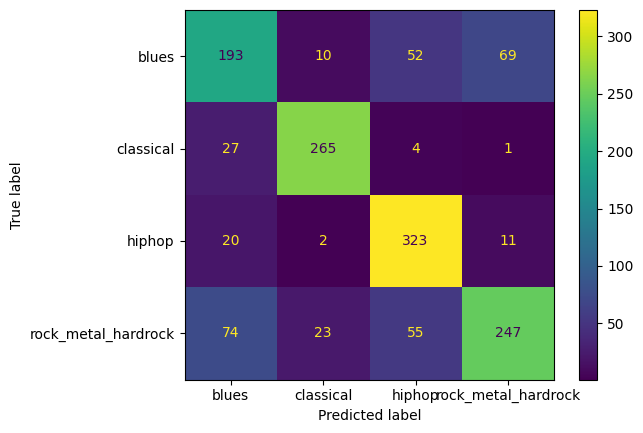

In [ ]:
set_seed(SEED)
cnn_pooling_padding = ConvolutionalNet_with_pooling_padding().to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt",loss_function)

In [ ]:
set_seed(SEED)
model_conv_pooling_padding = ConvolutionalNet_with_pooling_padding().to(device)
opt4 = Adagrad(model_conv_pooling_padding.parameters(), lr=2e-3)

Epoch   0: Train Loss = 1.74044
Epoch   0: Valid Loss = 1.28952
Epoch   0: Valid f1_score = 0.33475
Epoch   0: Valid Acurracy = 0.43875
Epoch   1: Train Loss = 1.10356
Epoch   1: Valid Loss = 0.96655
Epoch   1: Valid f1_score = 0.57445
Epoch   1: Valid Acurracy = 0.60750
Epoch   2: Train Loss = 0.88629
Epoch   2: Valid Loss = 0.91848
Epoch   2: Valid f1_score = 0.58492
Epoch   2: Valid Acurracy = 0.59375
Epoch   3: Train Loss = 0.76379
Epoch   3: Valid Loss = 0.75792
Epoch   3: Valid f1_score = 0.68017
Epoch   3: Valid Acurracy = 0.69750
Epoch   4: Train Loss = 0.68482
Epoch   4: Valid Loss = 0.72676
Epoch   4: Valid f1_score = 0.70315
Epoch   4: Valid Acurracy = 0.69875
Epoch   5: Train Loss = 0.64658
Epoch   5: Valid Loss = 0.73076
Epoch   5: Valid f1_score = 0.71462
Epoch   5: Valid Acurracy = 0.71000
Epoch   6: Train Loss = 0.57771
Epoch   6: Valid Loss = 0.74371
Epoch   6: Valid f1_score = 0.69630
Epoch   6: Valid Acurracy = 0.70625
Epoch   7: Train Loss = 0.53457
Epoch   7: Valid

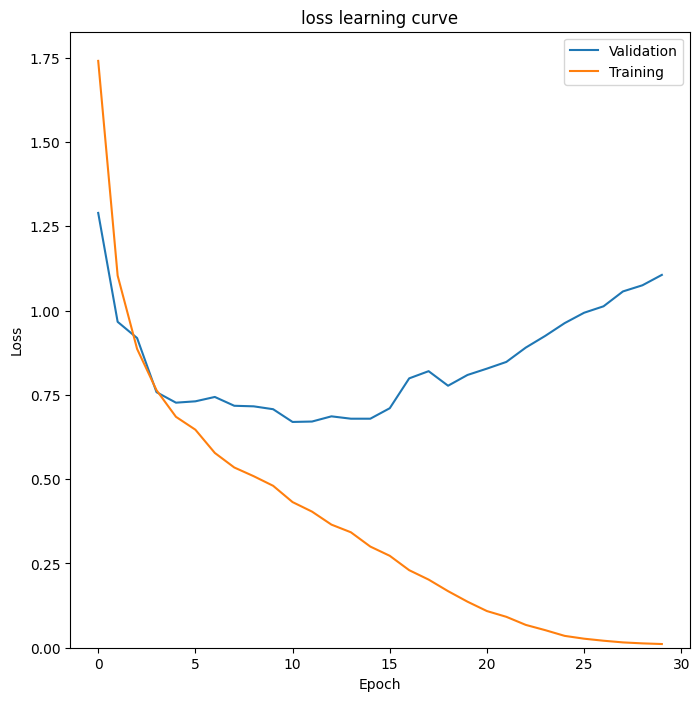

In [ ]:
cnn_pooling_padding = train_function(30, train_dataloader_mel, opt4, loss_function, model_conv_pooling_padding, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt", validation_dataloader_mel)

Valid Loss = 0.75989
Valid f1_score = 0.74963
Valid Acurracy = 0.74201


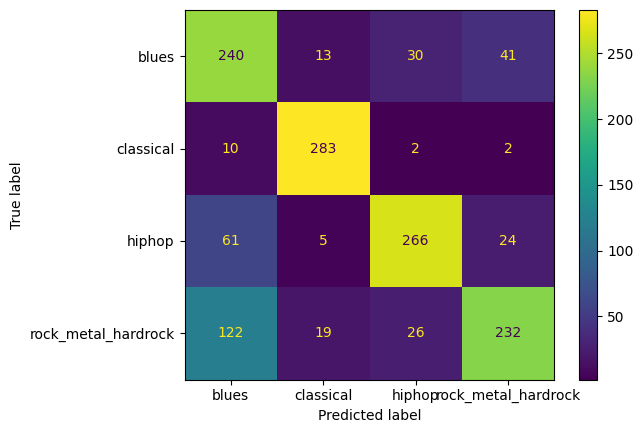

In [ ]:
#set_seed(SEED)
#cnn_pooling_padding = ConvolutionalNet_with_pooling_padding().to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt", loss_function)

In [ ]:
set_seed(SEED)
model_conv_pooling_padding = ConvolutionalNet_with_pooling_padding().to(device)
opt5 = torch.optim.AdamW(model_conv_pooling_padding.parameters(), lr=2e-3)

Epoch   0: Train Loss = 4.58426
Epoch   0: Valid Loss = 1.03258
Epoch   0: Valid f1_score = 0.51955
Epoch   0: Valid Acurracy = 0.54000
Epoch   1: Train Loss = 0.96388
Epoch   1: Valid Loss = 1.09761
Epoch   1: Valid f1_score = 0.42744
Epoch   1: Valid Acurracy = 0.51750
Epoch   2: Train Loss = 0.79707
Epoch   2: Valid Loss = 0.81461
Epoch   2: Valid f1_score = 0.67356
Epoch   2: Valid Acurracy = 0.66750
Epoch   3: Train Loss = 0.67982
Epoch   3: Valid Loss = 0.77869
Epoch   3: Valid f1_score = 0.69784
Epoch   3: Valid Acurracy = 0.70375
Epoch   4: Train Loss = 0.56999
Epoch   4: Valid Loss = 0.66973
Epoch   4: Valid f1_score = 0.74708
Epoch   4: Valid Acurracy = 0.74750
Epoch   5: Train Loss = 0.50622
Epoch   5: Valid Loss = 0.71422
Epoch   5: Valid f1_score = 0.72810
Epoch   5: Valid Acurracy = 0.72375
Epoch   6: Train Loss = 0.45201
Epoch   6: Valid Loss = 0.65344
Epoch   6: Valid f1_score = 0.76840
Epoch   6: Valid Acurracy = 0.76875
Epoch   7: Train Loss = 0.35351
Epoch   7: Valid

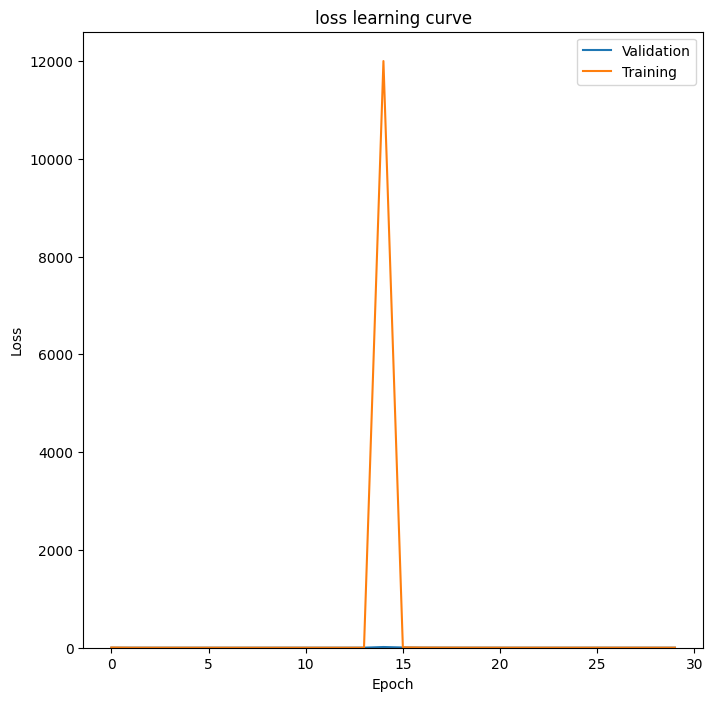

In [ ]:
cnn_pooling_padding = train_function(30, train_dataloader_mel, opt5, loss_function, model_conv_pooling_padding, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" , validation_dataloader_mel)

Valid Loss = 0.68039
Valid f1_score = 0.73176
Valid Acurracy = 0.72602


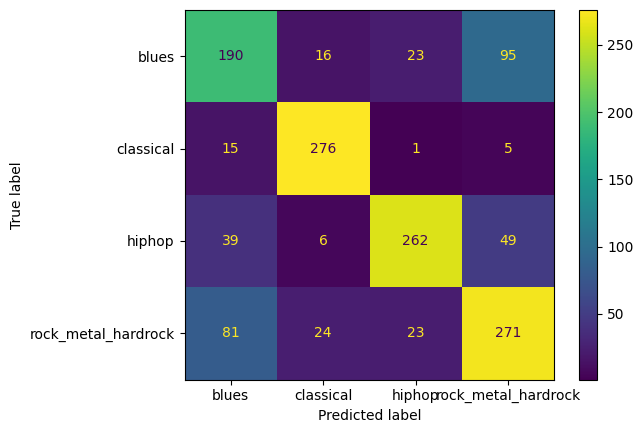

In [ ]:
#set_seed(SEED)
#cnn_pooling_padding = ConvolutionalNet_with_pooling_padding().to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding , "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" , loss_function)

In [ ]:
set_seed(SEED)
model_conv_pooling_padding = ConvolutionalNet_with_pooling_padding().to(device)
opt6 = torch.optim.Adamax(model_conv_pooling_padding.parameters(), lr=2e-3)

Epoch   0: Train Loss = 1.76332
Epoch   0: Valid Loss = 1.02631
Epoch   0: Valid f1_score = 0.59501
Epoch   0: Valid Acurracy = 0.60375
Epoch   1: Train Loss = 0.97395
Epoch   1: Valid Loss = 1.09036
Epoch   1: Valid f1_score = 0.39795
Epoch   1: Valid Acurracy = 0.50625
Epoch   2: Train Loss = 0.81037
Epoch   2: Valid Loss = 0.85111
Epoch   2: Valid f1_score = 0.63004
Epoch   2: Valid Acurracy = 0.64625
Epoch   3: Train Loss = 0.71036
Epoch   3: Valid Loss = 0.67244
Epoch   3: Valid f1_score = 0.73776
Epoch   3: Valid Acurracy = 0.74750
Epoch   4: Train Loss = 0.61649
Epoch   4: Valid Loss = 0.70411
Epoch   4: Valid f1_score = 0.70390
Epoch   4: Valid Acurracy = 0.70375
Epoch   5: Train Loss = 0.53583
Epoch   5: Valid Loss = 0.75126
Epoch   5: Valid f1_score = 0.71277
Epoch   5: Valid Acurracy = 0.70375
Epoch   6: Train Loss = 0.47447
Epoch   6: Valid Loss = 0.78965
Epoch   6: Valid f1_score = 0.68320
Epoch   6: Valid Acurracy = 0.69000
Epoch   7: Train Loss = 0.39324
Epoch   7: Valid

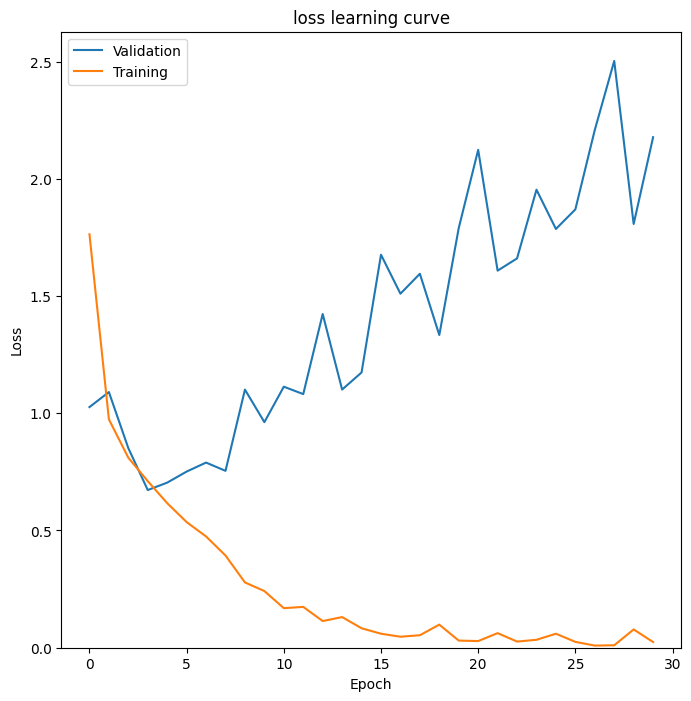

In [ ]:
cnn_pooling_padding = train_function(30, train_dataloader_mel, opt6, loss_function, model_conv_pooling_padding, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" , validation_dataloader_mel)

Valid Loss = 0.67901
Valid f1_score = 0.73812
Valid Acurracy = 0.74201


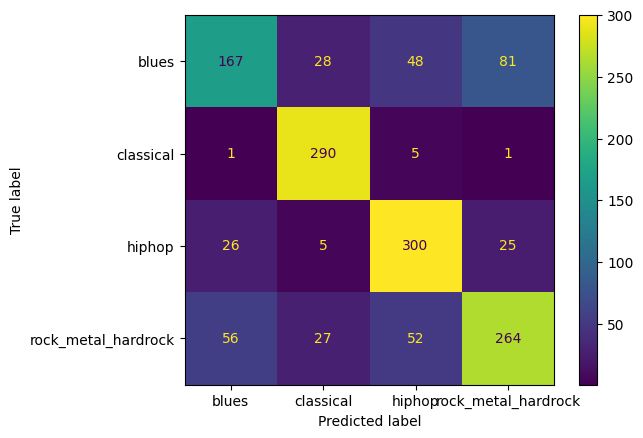

In [ ]:
#set_seed(SEED)
#model_conv_pooling_padding = ConvolutionalNet_with_pooling_padding().to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt"  ,loss_function)

In [ ]:
torch.manual_seed(SEED)
model_conv_pooling_padding = ConvolutionalNet_with_pooling_padding().to(device)
opt6 = torch.optim.Adadelta(model_conv_pooling_padding.parameters(), lr=2e-3)

Epoch   0: Train Loss = 1.36888
Epoch   0: Valid Loss = 1.34341
Epoch   0: Valid f1_score = 0.30678
Epoch   0: Valid Acurracy = 0.43125
Epoch   1: Train Loss = 1.31025
Epoch   1: Valid Loss = 1.27631
Epoch   1: Valid f1_score = 0.30381
Epoch   1: Valid Acurracy = 0.44500
Epoch   2: Train Loss = 1.23776
Epoch   2: Valid Loss = 1.20612
Epoch   2: Valid f1_score = 0.40903
Epoch   2: Valid Acurracy = 0.46000
Epoch   3: Train Loss = 1.17309
Epoch   3: Valid Loss = 1.15237
Epoch   3: Valid f1_score = 0.30796
Epoch   3: Valid Acurracy = 0.44125
Epoch   4: Train Loss = 1.12578
Epoch   4: Valid Loss = 1.09757
Epoch   4: Valid f1_score = 0.39728
Epoch   4: Valid Acurracy = 0.48125
Epoch   5: Train Loss = 1.08525
Epoch   5: Valid Loss = 1.07609
Epoch   5: Valid f1_score = 0.54676
Epoch   5: Valid Acurracy = 0.54250
Epoch   6: Train Loss = 1.05372
Epoch   6: Valid Loss = 1.05194
Epoch   6: Valid f1_score = 0.50262
Epoch   6: Valid Acurracy = 0.53625
Epoch   7: Train Loss = 1.03015
Epoch   7: Valid

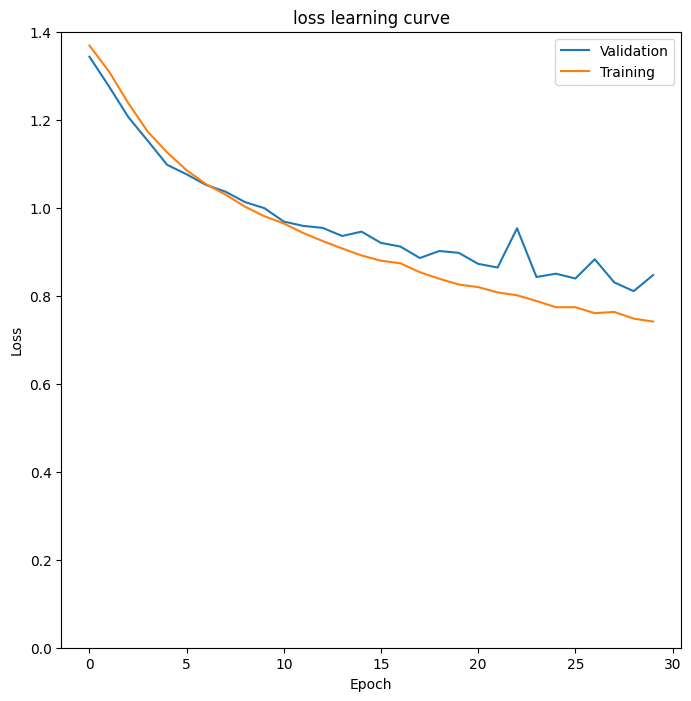

In [ ]:
cnn_pooling_padding = train_function(30, train_dataloader_mel, opt6, loss_function, model_conv_pooling_padding, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,validation_dataloader_mel)

Valid Loss = 0.83485
Valid f1_score = 0.65751
Valid Acurracy = 0.64971


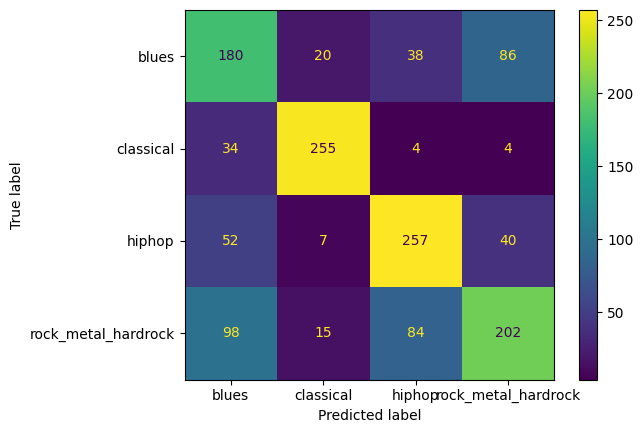

In [ ]:
#set_seed(SEED)
#model_conv_pooling_padding = ConvolutionalNet_with_pooling_padding().to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding , "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,loss_function)

**Results in the test set for various optimizers**

|           |  SGD  |  Adam | Adagrad |AdamW|Adadelta|Adamax|
|-----------|-------|-------|-------|-------|-------|-------|
| Accuracy  |0.69113|0.74709|0.74201|0.72602|0.64971|0.74201|
| f1-score  |0.69617|0.74750|0.74963|0.73176|0.65751|0.73812|

**From the above results, it appears that the best snapshot of all the corresponding snapshots for each optimizer, i.e., the highest value of the f1 metric, is achieved by the Adagrad optimization algorithm.**

###**Question 3: Improving Performance**

**Step 2: Activation functions**


**The reason that activation functions are used is to enable the network to "learn" more complex correlations in the data.**

In [ ]:
activation1 = nn.ELU()
set_seed(SEED)
model_conv_pooling_padding_activation = ConvolutionalNet_with_pooling_padding(activation1).to(device)
print(model_conv_pooling_padding_activation)
#Change model.weights to the same type of training features.
#target_dtype = torch.float64
#for param in model.parameters():
  #param.data = param.data.to(target_dtype)
#Initialized optimizer object
opt_act = Adagrad(model_conv_pooling_padding_activation.parameters(), lr=2e-3)


ConvolutionalNet_with_pooling_padding(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=32, bias=True)
  (dense5): Linear(in_features=32, out_features=4, bias=True)
  (activation): ELU(alpha=1.0)
)


Epoch   0: Train Loss = 1.37393
Epoch   0: Valid Loss = 1.16770
Epoch   0: Valid f1_score = 0.51001
Epoch   0: Valid Acurracy = 0.58250
Epoch   1: Train Loss = 0.96747
Epoch   1: Valid Loss = 0.81592
Epoch   1: Valid f1_score = 0.64907
Epoch   1: Valid Acurracy = 0.66500
Epoch   2: Train Loss = 0.74437
Epoch   2: Valid Loss = 0.71791
Epoch   2: Valid f1_score = 0.71460
Epoch   2: Valid Acurracy = 0.71625
Epoch   3: Train Loss = 0.64852
Epoch   3: Valid Loss = 0.67616
Epoch   3: Valid f1_score = 0.70775
Epoch   3: Valid Acurracy = 0.72125
Epoch   4: Train Loss = 0.58872
Epoch   4: Valid Loss = 0.65246
Epoch   4: Valid f1_score = 0.75269
Epoch   4: Valid Acurracy = 0.75250
Epoch   5: Train Loss = 0.56482
Epoch   5: Valid Loss = 0.61550
Epoch   5: Valid f1_score = 0.76001
Epoch   5: Valid Acurracy = 0.75625
Epoch   6: Train Loss = 0.51248
Epoch   6: Valid Loss = 0.62037
Epoch   6: Valid f1_score = 0.74944
Epoch   6: Valid Acurracy = 0.75750
Epoch   7: Train Loss = 0.48366
Epoch   7: Valid

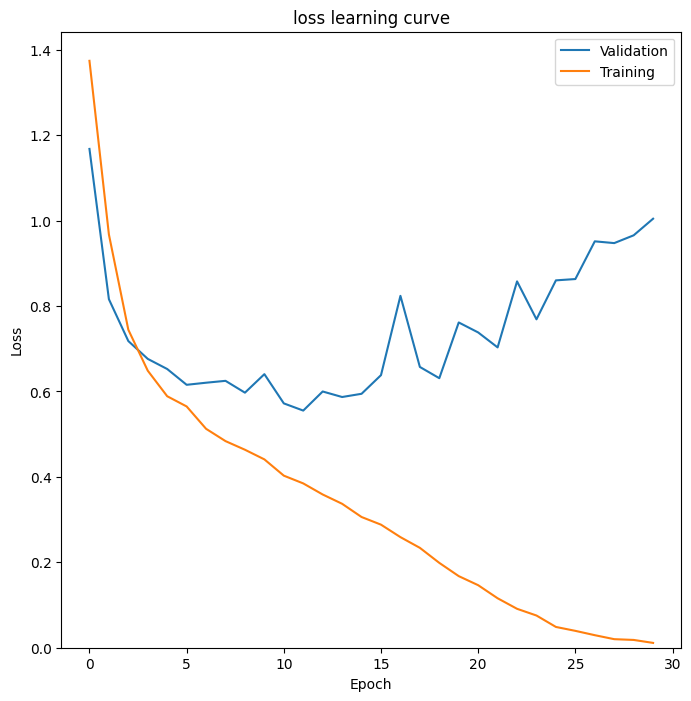

In [ ]:
cnn_pooling_padding_act = train_function(30, train_dataloader_mel, opt_act, loss_function, model_conv_pooling_padding_activation, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" , validation_dataloader_mel)

Valid Loss = 0.60785
Valid f1_score = 0.77120
Valid Acurracy = 0.76890


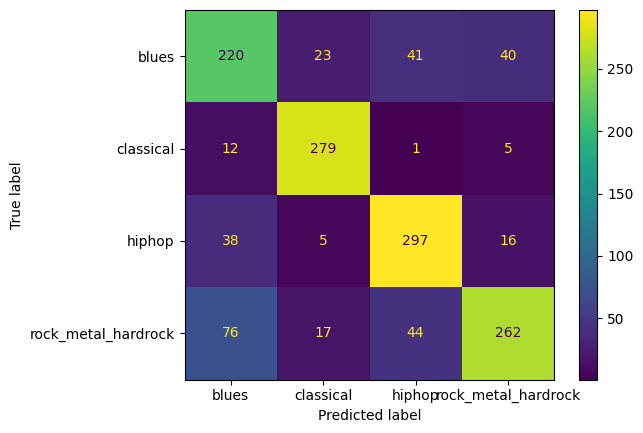

In [ ]:
#set_seed(SEED)
#cnn_pooling_padding_act = ConvolutionalNet_with_pooling_padding(activation1).to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding_act, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,loss_function)#The same test fucntion is runnig two times
#and it is giving exactly the same results, so the reproducibility is preserved.

In [ ]:
activation2 = nn.ReLU()

set_seed(SEED)
model_conv_pooling_padding_activation = ConvolutionalNet_with_pooling_padding(activation2).to(device)
print(model_conv_pooling_padding_activation)
#Initialized optimizer object
opt_act = Adagrad(model_conv_pooling_padding_activation.parameters(), lr=2e-3)

ConvolutionalNet_with_pooling_padding(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=32, bias=True)
  (dense5): Linear(in_features=32, out_features=4, bias=True)
  (activation): ReLU()
)


Epoch   0: Train Loss = 1.37924
Epoch   0: Valid Loss = 1.28049
Epoch   0: Valid f1_score = 0.27213
Epoch   0: Valid Acurracy = 0.40500
Epoch   1: Train Loss = 1.00481
Epoch   1: Valid Loss = 0.87663
Epoch   1: Valid f1_score = 0.61471
Epoch   1: Valid Acurracy = 0.63500
Epoch   2: Train Loss = 0.79555
Epoch   2: Valid Loss = 0.86079
Epoch   2: Valid f1_score = 0.63365
Epoch   2: Valid Acurracy = 0.63875
Epoch   3: Train Loss = 0.68737
Epoch   3: Valid Loss = 0.72859
Epoch   3: Valid f1_score = 0.69718
Epoch   3: Valid Acurracy = 0.70375
Epoch   4: Train Loss = 0.61151
Epoch   4: Valid Loss = 0.70486
Epoch   4: Valid f1_score = 0.71755
Epoch   4: Valid Acurracy = 0.71375
Epoch   5: Train Loss = 0.55978
Epoch   5: Valid Loss = 0.67174
Epoch   5: Valid f1_score = 0.73207
Epoch   5: Valid Acurracy = 0.72750
Epoch   6: Train Loss = 0.52163
Epoch   6: Valid Loss = 0.72418
Epoch   6: Valid f1_score = 0.70788
Epoch   6: Valid Acurracy = 0.71000
Epoch   7: Train Loss = 0.48134
Epoch   7: Valid

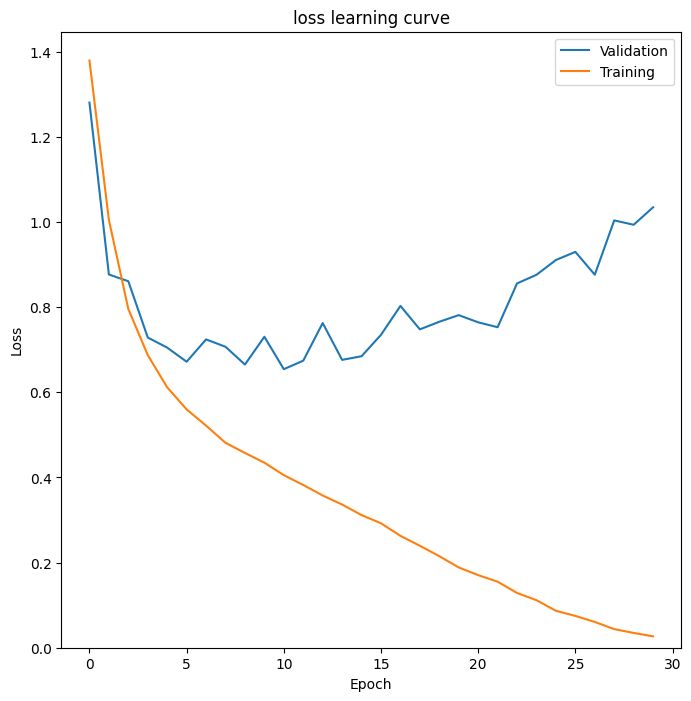

In [ ]:
cnn_pooling_padding_act = train_function(30, train_dataloader_mel, opt_act, loss_function, model_conv_pooling_padding_activation, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" , validation_dataloader_mel)

Valid Loss = 0.85608
Valid f1_score = 0.73211
Valid Acurracy = 0.72602


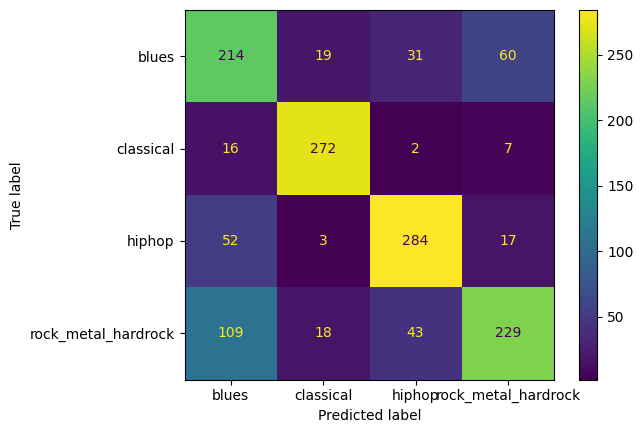

In [ ]:
#set_seed(SEED)
#cnn_pooling_padding_act = ConvolutionalNet_with_pooling_padding(activation2).to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding_act, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,loss_function)

In [ ]:
activation3 = nn.LeakyReLU()

set_seed(SEED)
model_conv_pooling_padding_activation = ConvolutionalNet_with_pooling_padding(activation3).to(device)
print(model_conv_pooling_padding_activation)
#Initialized optimizer object
opt_act = Adagrad(model_conv_pooling_padding_activation.parameters(), lr=2e-3)

ConvolutionalNet_with_pooling_padding(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=32, bias=True)
  (dense5): Linear(in_features=32, out_features=4, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
)


Epoch   0: Train Loss = 1.28443
Epoch   0: Valid Loss = 1.07424
Epoch   0: Valid f1_score = 0.38222
Epoch   0: Valid Acurracy = 0.46875
Epoch   1: Train Loss = 0.99893
Epoch   1: Valid Loss = 0.92434
Epoch   1: Valid f1_score = 0.47537
Epoch   1: Valid Acurracy = 0.55125
Epoch   2: Train Loss = 0.86302
Epoch   2: Valid Loss = 0.93151
Epoch   2: Valid f1_score = 0.59926
Epoch   2: Valid Acurracy = 0.59750
Epoch   3: Train Loss = 0.73735
Epoch   3: Valid Loss = 0.75915
Epoch   3: Valid f1_score = 0.68178
Epoch   3: Valid Acurracy = 0.69250
Epoch   4: Train Loss = 0.65932
Epoch   4: Valid Loss = 0.75412
Epoch   4: Valid f1_score = 0.69598
Epoch   4: Valid Acurracy = 0.69125
Epoch   5: Train Loss = 0.60195
Epoch   5: Valid Loss = 0.68038
Epoch   5: Valid f1_score = 0.72752
Epoch   5: Valid Acurracy = 0.72375
Epoch   6: Train Loss = 0.55504
Epoch   6: Valid Loss = 0.75308
Epoch   6: Valid f1_score = 0.69680
Epoch   6: Valid Acurracy = 0.70500
Epoch   7: Train Loss = 0.50576
Epoch   7: Valid

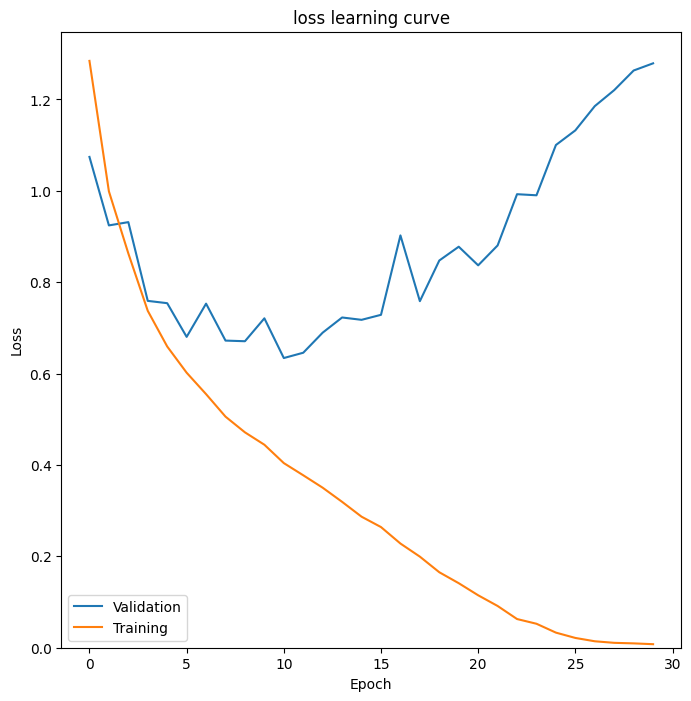

In [ ]:
cnn_pooling_padding_act = train_function(30, train_dataloader_mel, opt_act, loss_function, model_conv_pooling_padding_activation, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" , validation_dataloader_mel)

Valid Loss = 0.68397
Valid f1_score = 0.74078
Valid Acurracy = 0.73328


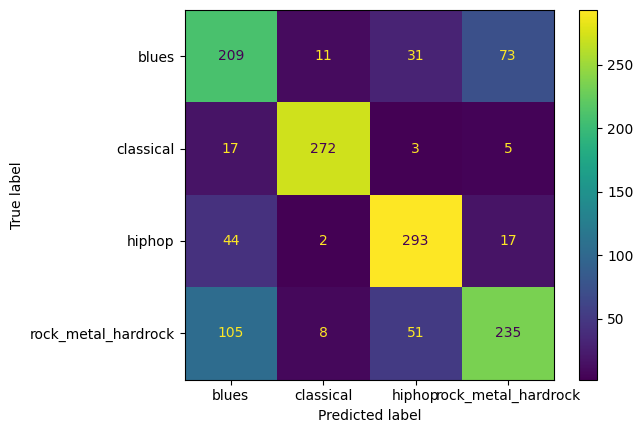

In [ ]:
#set_seed(SEED)
#cnn_pooling_padding_act = ConvolutionalNet_with_pooling_padding(activation3).to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding_act, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,loss_function)

In [ ]:
activation4 = nn.Tanh()

set_seed(SEED)
model_conv_pooling_padding_activation = ConvolutionalNet_with_pooling_padding(activation4).to(device)
print(model_conv_pooling_padding_activation)
#Initialized optimizer object
opt_act = Adagrad(model_conv_pooling_padding_activation.parameters(), lr=2e-3)

ConvolutionalNet_with_pooling_padding(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=32, bias=True)
  (dense5): Linear(in_features=32, out_features=4, bias=True)
  (activation): Tanh()
)


Epoch   0: Train Loss = 1.39439
Epoch   0: Valid Loss = 1.38748
Epoch   0: Valid f1_score = 0.10000
Epoch   0: Valid Acurracy = 0.25000
Epoch   1: Train Loss = 1.38767
Epoch   1: Valid Loss = 1.38675
Epoch   1: Valid f1_score = 0.10000
Epoch   1: Valid Acurracy = 0.25000
Epoch   2: Train Loss = 1.38781
Epoch   2: Valid Loss = 1.38640
Epoch   2: Valid f1_score = 0.10000
Epoch   2: Valid Acurracy = 0.25000
Epoch   3: Train Loss = 1.38751
Epoch   3: Valid Loss = 1.38657
Epoch   3: Valid f1_score = 0.10000
Epoch   3: Valid Acurracy = 0.25000
Epoch   4: Train Loss = 1.38730
Epoch   4: Valid Loss = 1.38664
Epoch   4: Valid f1_score = 0.10000
Epoch   4: Valid Acurracy = 0.25000
Epoch   5: Train Loss = 1.38688
Epoch   5: Valid Loss = 1.38652
Epoch   5: Valid f1_score = 0.10000
Epoch   5: Valid Acurracy = 0.25000
Epoch   6: Train Loss = 1.38713
Epoch   6: Valid Loss = 1.38648
Epoch   6: Valid f1_score = 0.10000
Epoch   6: Valid Acurracy = 0.25000
Epoch   7: Train Loss = 1.38700
Epoch   7: Valid

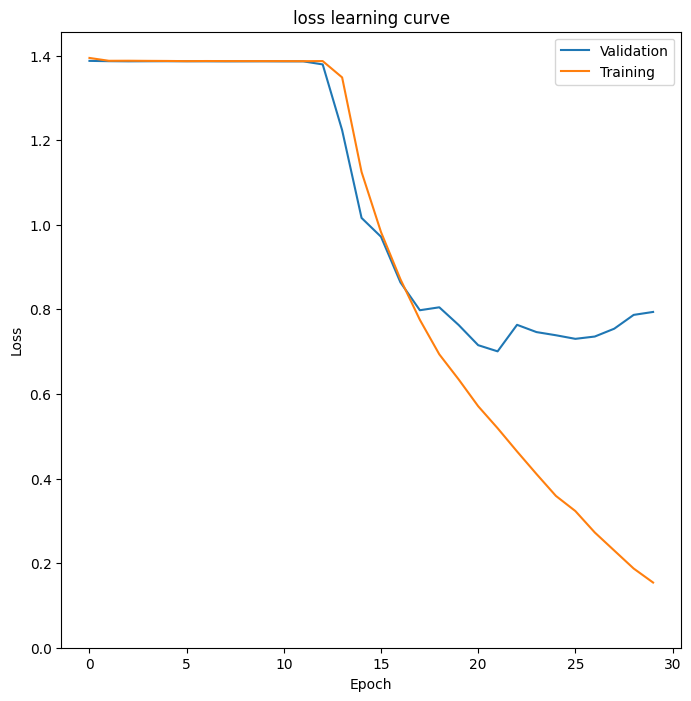

In [ ]:
cnn_pooling_padding_act = train_function(30, train_dataloader_mel, opt_act, loss_function, model_conv_pooling_padding_activation, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" , validation_dataloader_mel)

Valid Loss = 0.74140
Valid f1_score = 0.73150
Valid Acurracy = 0.72820


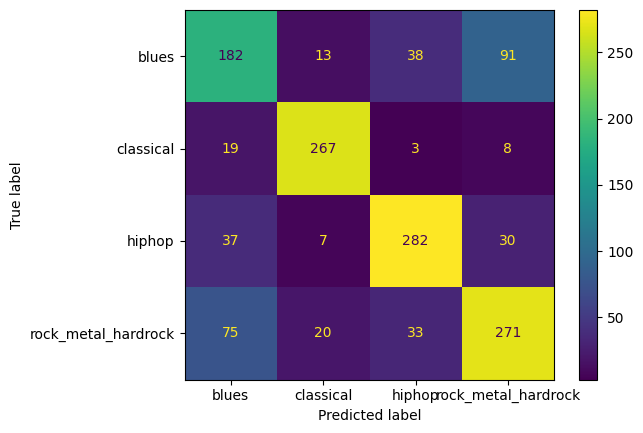

In [ ]:
#set_seed(SEED)
#cnn_pooling_padding_act = ConvolutionalNet_with_pooling_padding(activation4).to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding_act, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,loss_function)

ConvolutionalNet_with_pooling_padding(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=32, bias=True)
  (dense5): Linear(in_features=32, out_features=4, bias=True)
  (activation): Softplus(beta=1, threshold=20)
)
Epoch   0: Train Loss = 1.40159
Epoch   0: Valid Loss = 1.38648
Epoch   0: Valid f1_score = 0.10000
Epoch   0: Valid Acurracy = 0.25000
Epoch   1: Tra

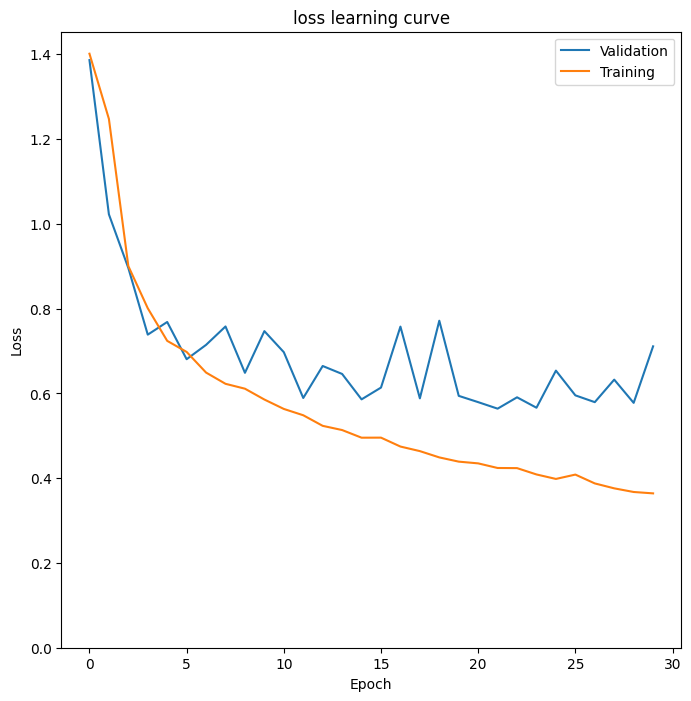

In [ ]:
activation5 = nn.Softplus()
set_seed(SEED)
model_conv_pooling_padding_activation = ConvolutionalNet_with_pooling_padding(activation5).to(device)
print(model_conv_pooling_padding_activation)
#Initialized optimizer object
opt_act = Adagrad(model_conv_pooling_padding_activation.parameters(), lr=2e-3)
cnn_pooling_padding_act = train_function(30, train_dataloader_mel, opt_act, loss_function, model_conv_pooling_padding_activation, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" , validation_dataloader_mel)

Valid Loss = 0.62498
Valid f1_score = 0.75280
Valid Acurracy = 0.75654


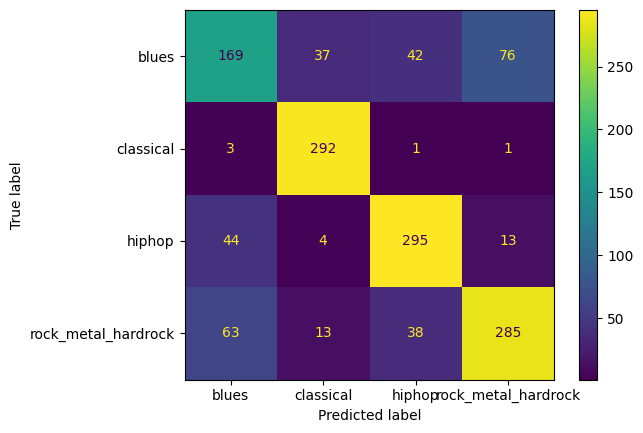

In [ ]:
#set_seed(SEED)
#cnn_pooling_padding_act = ConvolutionalNet_with_pooling_padding(activation5).to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding_act, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,loss_function)

ConvolutionalNet_with_pooling_padding(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=32, bias=True)
  (dense5): Linear(in_features=32, out_features=4, bias=True)
  (activation): PReLU(num_parameters=1)
)
Epoch   0: Train Loss = 1.34521
Epoch   0: Valid Loss = 1.13615
Epoch   0: Valid f1_score = 0.36790
Epoch   0: Valid Acurracy = 0.46125
Epoch   1: Train Loss

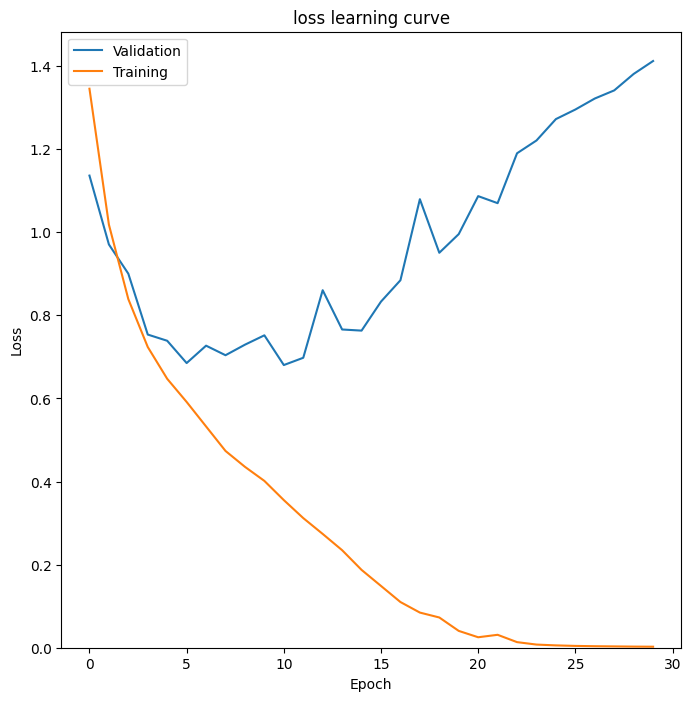

In [ ]:
activation6 = nn.PReLU()
set_seed(SEED)
model_conv_pooling_padding_activation = ConvolutionalNet_with_pooling_padding(activation6).to(device)
print(model_conv_pooling_padding_activation)
#Initialized optimizer object
opt_act = Adagrad(model_conv_pooling_padding_activation.parameters(), lr=2e-3)
cnn_pooling_padding_act = train_function(30, train_dataloader_mel, opt_act, loss_function, model_conv_pooling_padding_activation, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" , validation_dataloader_mel)

Valid Loss = 0.98129
Valid f1_score = 0.74366
Valid Acurracy = 0.73692


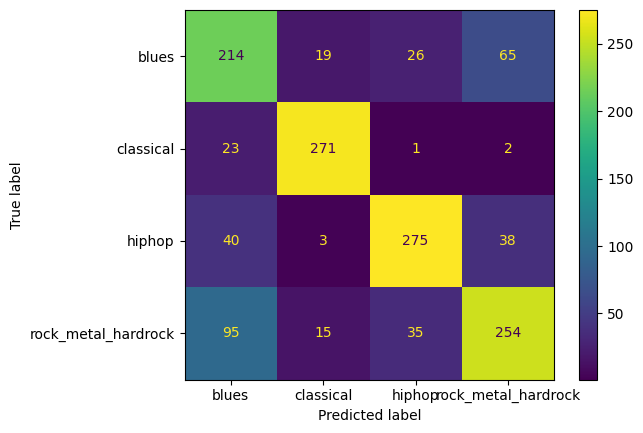

In [ ]:
#set_seed(SEED)
#cnn_pooling_padding_act = ConvolutionalNet_with_pooling_padding(activation6).to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding_act, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,loss_function)

**Results in the control set for the Adagrad optimizer and for the various activation functions for the same training and evaluation functions as defined in steps 3 and 4 of Question 1.**

|           |  ReLU | Tanh  | LeakyReLU| PRELU |Softplus|  ELU |
|-----------|-------|-------|----------|-------|--------|------|
| Accuracy  |0.72602|0.72820|  0.73328 | 0.73692|0.75654|0.76890|
| f1-score  |0.73211|0.73150| 0.74078 |0.74366|0.75280|0.77120|

**Considering Adagrad from the previous question as the optimizer with the highest f1 value, the activation function that essentially has the best snapshot is ELU because it has the highest f1 metric values, but also secondarily because it has the most true positives on average across all music classes (hiphop, rock metal hardrock, classical, blues) through the confusion matrix in relation to the other activation functions both during training and in the test set.**

**Step 3: Learning rate scheduler**

**The static learning rate (lr = 0.002) is not the best choice for all execution steps, as it may be too small for the initial steps where we want larger weight adjustments, and large for the final steps, where we have approached a good snapshot of the model and do not want to stray too far from it.**

**For the above reason, learning rate schedulers will be used, which dynamically adjust the learning rate according to the history of losses. Each scheduler is given the argument verbose=True so that the dynamic changes made can be monitored. The training function is modified slightly to include the respective learning rate scheduler.**

ConvolutionalNet_with_pooling_padding(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=32, bias=True)
  (dense5): Linear(in_features=32, out_features=4, bias=True)
  (activation): ELU(alpha=1.0)
)
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 1.8000e-03.
Epoch   0: Train Loss = 1.37393
Epoch   0: Valid Loss = 1.16770
Ep

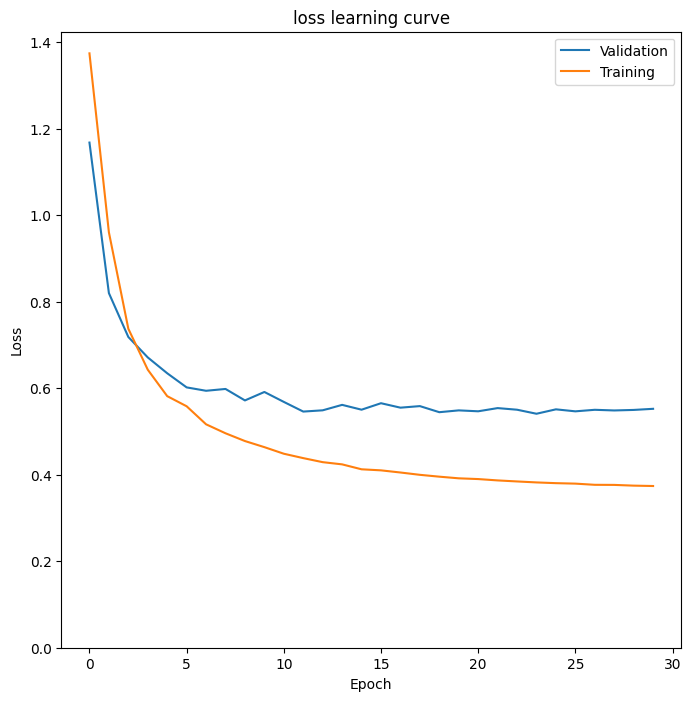

In [ ]:
activation = nn.ELU()
set_seed(SEED)
model_conv_pooling_padding_activation_sched = ConvolutionalNet_with_pooling_padding(activation).to(device)
print(model_conv_pooling_padding_activation_sched)
#Change model.weights to the same type of training features.
#target_dtype = torch.float64
#for param in model_conv_pooling_padding_activation.parameters():
  #param.data = param.data.to(target_dtype)
#Initialized optimizer object
optimizer = Adagrad(model_conv_pooling_padding_activation_sched.parameters(), lr=2e-3)

scheduler1= torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9, verbose = True)

cnn_pooling_padding_act_lrsched = train_function(30, train_dataloader_mel, optimizer, loss_function, model_conv_pooling_padding_activation_sched, scheduler1, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,validation_dataloader_mel)


Valid Loss = 0.58585
Valid f1_score = 0.77321
Valid Acurracy = 0.77035


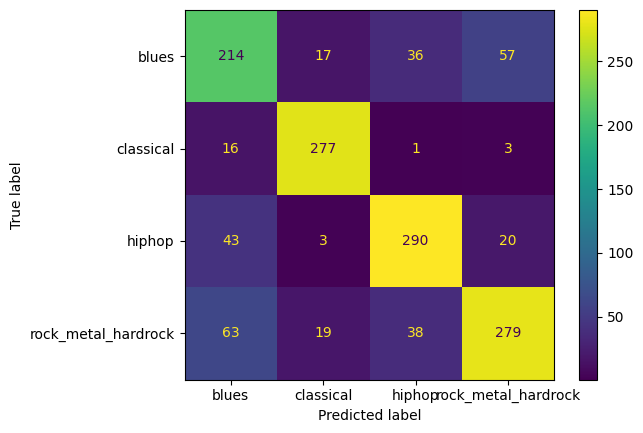

In [ ]:
#set_seed(SEED)
#cnn_pooling_padding_act_lrsched = ConvolutionalNet_with_pooling_padding(activation).to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding_act_lrsched, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,loss_function)

ConvolutionalNet_with_pooling_padding(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=32, bias=True)
  (dense5): Linear(in_features=32, out_features=4, bias=True)
  (activation): ELU(alpha=1.0)
)
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 1.9900e-03.
Epoch   0: Train Loss = 1.37393
Epoch   0: Valid Loss = 1.16770
Ep

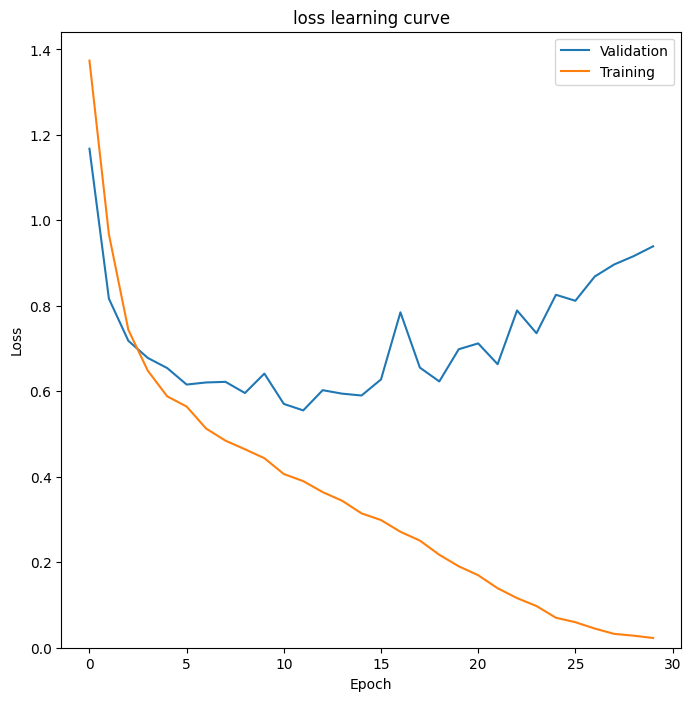

In [ ]:
activation = nn.ELU()
set_seed(SEED)
model_conv_pooling_padding_activation_sched = ConvolutionalNet_with_pooling_padding(activation).to(device)
print(model_conv_pooling_padding_activation_sched)
#Initialized optimizer object
optimizer = Adagrad(model_conv_pooling_padding_activation_sched.parameters(), lr=2e-3)
scheduler2= torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda = lambda epoch: 0.995, verbose = True)
cnn_pooling_padding_act_lrsched = train_function(30, train_dataloader_mel, optimizer, loss_function, model_conv_pooling_padding_activation_sched, scheduler2, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,validation_dataloader_mel)

Valid Loss = 0.78336
Valid f1_score = 0.76326
Valid Acurracy = 0.75872


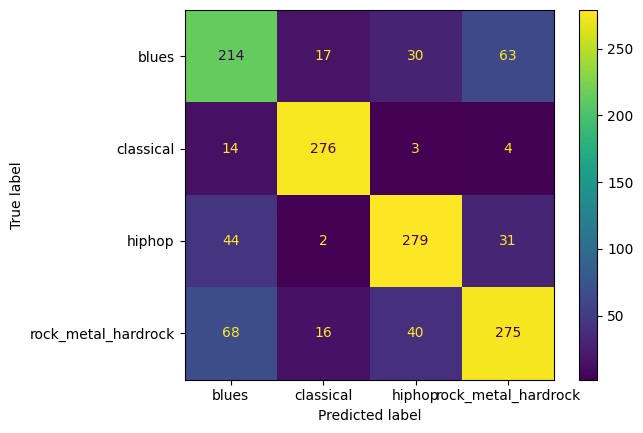

In [ ]:
#set_seed(SEED)
#cnn_pooling_padding_act_lrsched = ConvolutionalNet_with_pooling_padding(activation).to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding_act_lrsched, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,loss_function)

ConvolutionalNet_with_pooling_padding(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=32, bias=True)
  (dense5): Linear(in_features=32, out_features=4, bias=True)
  (activation): ELU(alpha=1.0)
)
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch   0: Train Loss = 1.37393
Epoch   0: Valid Loss = 1.16770
Ep

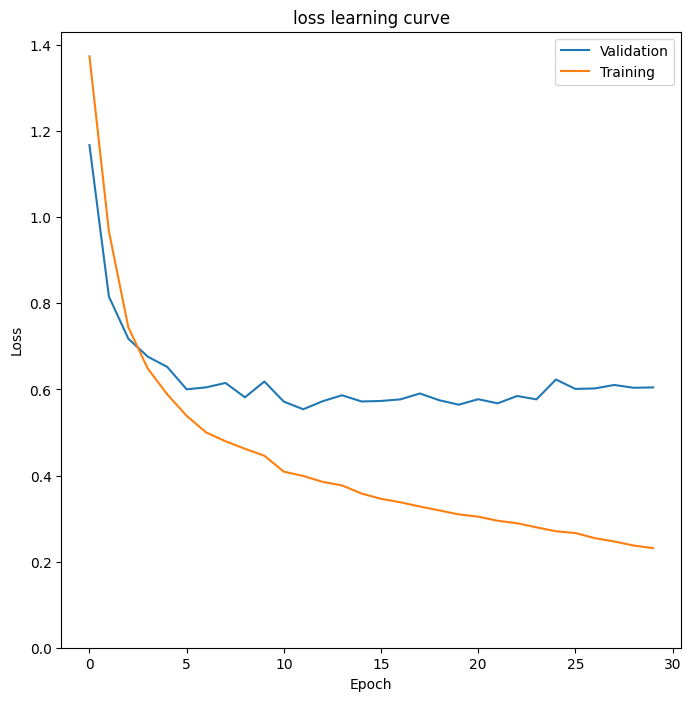

In [ ]:
set_seed(SEED)
model_conv_pooling_padding_activation_sched = ConvolutionalNet_with_pooling_padding(activation).to(device)
print(model_conv_pooling_padding_activation_sched)
#Initialized optimizer object
optimizer = Adagrad(model_conv_pooling_padding_activation_sched.parameters(), lr=2e-3)
scheduler3= torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15], gamma=0.7, verbose = True)
cnn_pooling_padding_act_lrsched = train_function(30, train_dataloader_mel, optimizer, loss_function, model_conv_pooling_padding_activation_sched, scheduler3, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt",validation_dataloader_mel)

Valid Loss = 0.62122
Valid f1_score = 0.76791
Valid Acurracy = 0.76381


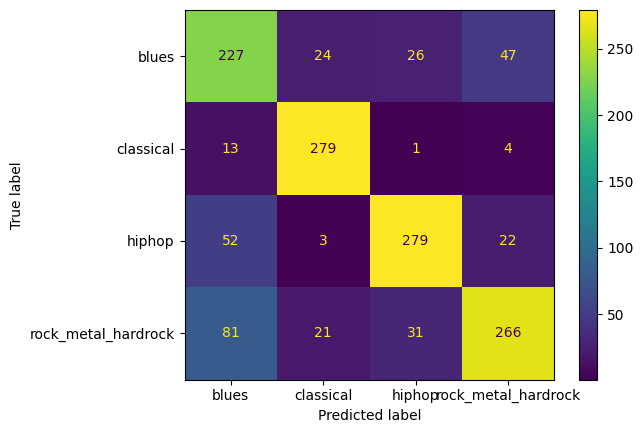

In [ ]:
#set_seed(SEED)
#cnn_pooling_padding_act_lrsched = ConvolutionalNet_with_pooling_padding(activation).to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding_act_lrsched, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,loss_function)

In [ ]:
set_seed(SEED)
model_conv_pooling_padding_activation_sched = ConvolutionalNet_with_pooling_padding(activation).to(device)
print(model_conv_pooling_padding_activation_sched)
#Initialized optimizer object
optimizer = Adagrad(model_conv_pooling_padding_activation_sched.parameters(), lr=2e-3)
scheduler4= torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.9, total_iters=6, verbose = True)

ConvolutionalNet_with_pooling_padding(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=32, bias=True)
  (dense5): Linear(in_features=32, out_features=4, bias=True)
  (activation): ELU(alpha=1.0)
)
Adjusting learning rate of group 0 to 1.8000e-03.


Adjusting learning rate of group 0 to 1.8333e-03.
Epoch   0: Train Loss = 1.21708
Epoch   0: Valid Loss = 0.93768
Epoch   0: Valid f1_score = 0.56126
Epoch   0: Valid Acurracy = 0.59375
Adjusting learning rate of group 0 to 1.8667e-03.
Epoch   1: Train Loss = 0.76879
Epoch   1: Valid Loss = 0.72618
Epoch   1: Valid f1_score = 0.71872
Epoch   1: Valid Acurracy = 0.72500
Adjusting learning rate of group 0 to 1.9000e-03.
Epoch   2: Train Loss = 0.64836
Epoch   2: Valid Loss = 0.67064
Epoch   2: Valid f1_score = 0.74365
Epoch   2: Valid Acurracy = 0.74250
Adjusting learning rate of group 0 to 1.9333e-03.
Epoch   3: Train Loss = 0.57307
Epoch   3: Valid Loss = 0.62136
Epoch   3: Valid f1_score = 0.74952
Epoch   3: Valid Acurracy = 0.75250
Adjusting learning rate of group 0 to 1.9667e-03.
Epoch   4: Train Loss = 0.51596
Epoch   4: Valid Loss = 0.64147
Epoch   4: Valid f1_score = 0.76439
Epoch   4: Valid Acurracy = 0.76375
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch   5: Train Los

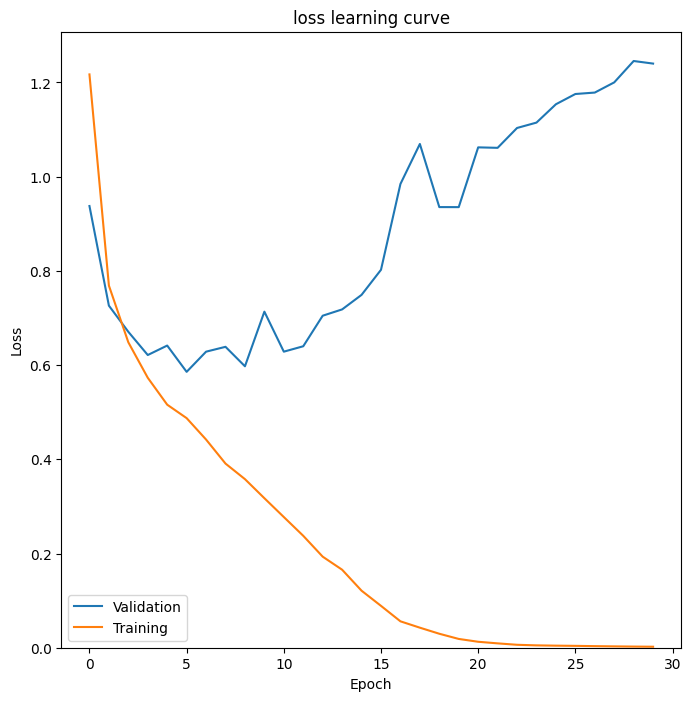

In [ ]:
cnn_pooling_padding_act_lrsched = train_function(30, train_dataloader_mel, optimizer, loss_function, model_conv_pooling_padding_activation_sched, scheduler4,"drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,validation_dataloader_mel)

Valid Loss = 1.17796
Valid f1_score = 0.75080
Valid Acurracy = 0.74709


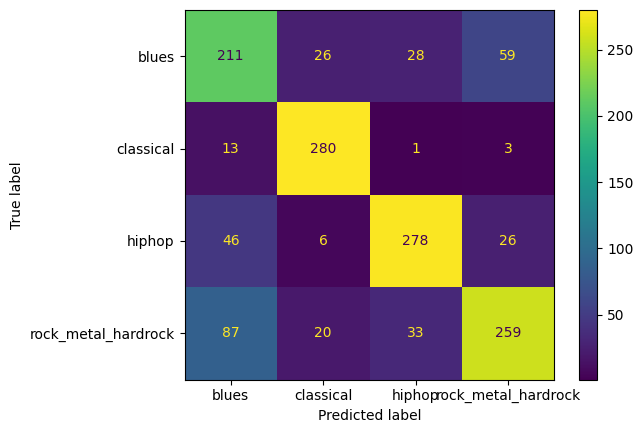

In [ ]:
#set_seed(SEED)
#cnn_pooling_padding_act_lrsched = ConvolutionalNet_with_pooling_padding(activation).to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding_act_lrsched, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,loss_function)

In [ ]:
set_seed(SEED)
model_conv_pooling_padding_activation_sched = ConvolutionalNet_with_pooling_padding(activation).to(device)
print(model_conv_pooling_padding_activation_sched)
#Initialized optimizer object
optimizer = Adagrad(model_conv_pooling_padding_activation_sched.parameters(), lr=2e-3)
scheduler5= torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=2e-4, verbose = True)

ConvolutionalNet_with_pooling_padding(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=32, bias=True)
  (dense5): Linear(in_features=32, out_features=4, bias=True)
  (activation): ELU(alpha=1.0)
)
Adjusting learning rate of group 0 to 2.0000e-03.


Adjusting learning rate of group 0 to 1.9560e-03.
Epoch   0: Train Loss = 1.37393
Epoch   0: Valid Loss = 1.16770
Epoch   0: Valid f1_score = 0.51001
Epoch   0: Valid Acurracy = 0.58250
Adjusting learning rate of group 0 to 1.8281e-03.
Epoch   1: Train Loss = 0.96652
Epoch   1: Valid Loss = 0.81916
Epoch   1: Valid f1_score = 0.64576
Epoch   1: Valid Acurracy = 0.66250
Adjusting learning rate of group 0 to 1.6290e-03.
Epoch   2: Train Loss = 0.73998
Epoch   2: Valid Loss = 0.71759
Epoch   2: Valid f1_score = 0.71202
Epoch   2: Valid Acurracy = 0.71375
Adjusting learning rate of group 0 to 1.3781e-03.
Epoch   3: Train Loss = 0.64077
Epoch   3: Valid Loss = 0.67203
Epoch   3: Valid f1_score = 0.71429
Epoch   3: Valid Acurracy = 0.72625
Adjusting learning rate of group 0 to 1.1000e-03.
Epoch   4: Train Loss = 0.57542
Epoch   4: Valid Loss = 0.64184
Epoch   4: Valid f1_score = 0.75200
Epoch   4: Valid Acurracy = 0.75250
Adjusting learning rate of group 0 to 8.2188e-04.
Epoch   5: Train Los

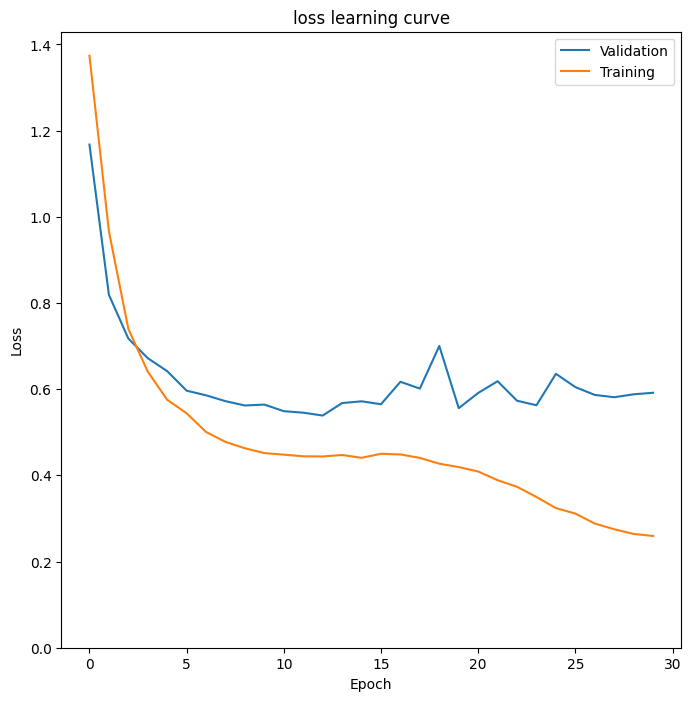

In [ ]:
cnn_pooling_padding_act_lrsched = train_function(30, train_dataloader_mel, optimizer, loss_function, model_conv_pooling_padding_activation_sched, scheduler5, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,validation_dataloader_mel)

Valid Loss = 0.62970
Valid f1_score = 0.75626
Valid Acurracy = 0.75145


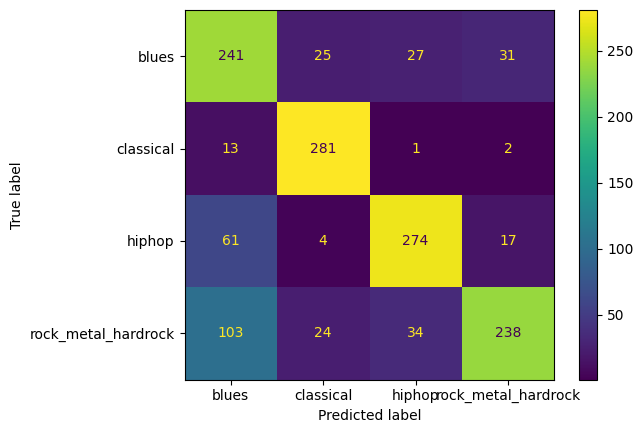

In [ ]:
#set_seed(SEED)
#cnn_pooling_padding_act_lrsched = ConvolutionalNet_with_pooling_padding(activation).to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, cnn_pooling_padding_act_lrsched, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,loss_function)

|           | MultiStepLR |ExponentialLR|  LinearLR |MultiplicativeLR|CosineAnnealingLR|
|-----------|-------------|-------------|----------|----------------|----------|
| Accuracy  |    0.76381  |  0.77035   |  0.75436 |    0.75872  |   0.75145 |
| f1-score  |   0.76791  | 0.77321   | 0.75080 |     0.76326   |   0.75626   |

**Essentially, the above results show that the model with Adagrad optimizer and softplus activation function improves, albeit slightly, in terms of the f1 metric value and the number of true positives from the confusion matrix, for each music category on average, using the ExponentialLR learning rate scheduler.**

**Step 4: Batch Normalization**

**To achieve specific statistical properties, normalization is usually performed at the input. However, when multiple layers are applied to the network and the weights are updated, the statistical properties of the input of each layer may differ from one batch to another. This does not help the training algorithm as it tries to learn from data whose distribution between batches changes slightly.**

**For this reason, normalization is applied to each convolutional layer (for this specific exercise, but more generally to any type of layer) normalization is applied to all elements of the batch by introducing pytorch's BatchNorm2d layers into the network architecture before each activation function of all convolutional layers.**



In [ ]:
activation = nn.ELU()
set_seed(SEED)
model_conv_batchnorm = ConvolutionalNet_with_pooling_padding(activation).to(device)
print(model_conv_batchnorm)
#Change model.weights to the same type of training features.
#target_dtype = torch.float64
#for param in model_conv_pooling_padding_activation.parameters():
  #param.data = param.data.to(target_dtype)
#Initialized optimizer object
optimizer= Adagrad(model_conv_batchnorm.parameters(), lr=2e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9, verbose = True)

ConvolutionalNet_with_pooling_padding(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)

Adjusting learning rate of group 0 to 1.8000e-03.
Epoch   0: Train Loss = 0.85168
Epoch   0: Valid Loss = 0.67162
Epoch   0: Valid f1_score = 0.71106
Epoch   0: Valid Acurracy = 0.71375
Adjusting learning rate of group 0 to 1.6200e-03.
Epoch   1: Train Loss = 0.60084
Epoch   1: Valid Loss = 0.62558
Epoch   1: Valid f1_score = 0.76021
Epoch   1: Valid Acurracy = 0.76500
Adjusting learning rate of group 0 to 1.4580e-03.
Epoch   2: Train Loss = 0.53345
Epoch   2: Valid Loss = 0.56844
Epoch   2: Valid f1_score = 0.76515
Epoch   2: Valid Acurracy = 0.76750
Adjusting learning rate of group 0 to 1.3122e-03.
Epoch   3: Train Loss = 0.47255
Epoch   3: Valid Loss = 0.57997
Epoch   3: Valid f1_score = 0.76503
Epoch   3: Valid Acurracy = 0.77125
Adjusting learning rate of group 0 to 1.1810e-03.
Epoch   4: Train Loss = 0.43013
Epoch   4: Valid Loss = 0.52242
Epoch   4: Valid f1_score = 0.79692
Epoch   4: Valid Acurracy = 0.79625
Adjusting learning rate of group 0 to 1.0629e-03.
Epoch   5: Train Los

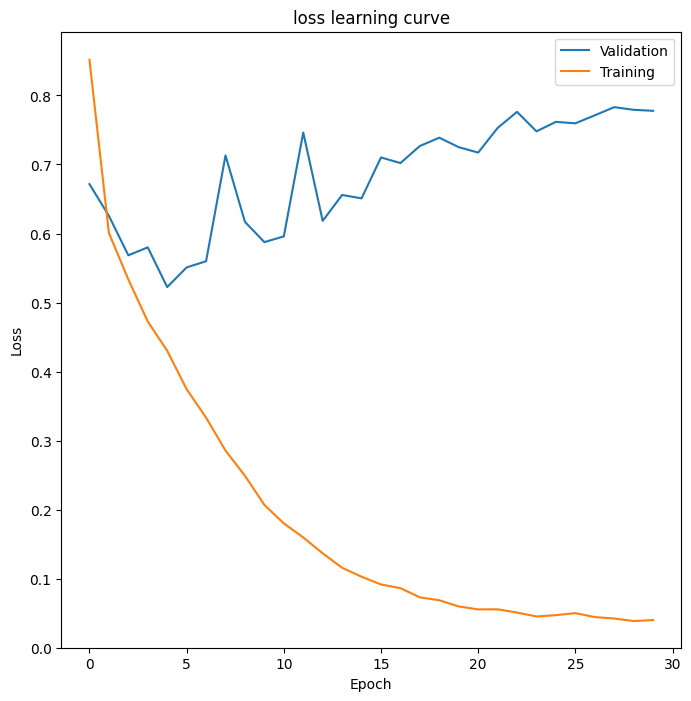

In [ ]:
cnn_pooling_padding_batchnorm= train_function(30, train_dataloader_mel, optimizer, loss_function, model_conv_batchnorm,scheduler, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,validation_dataloader_mel)

Valid Loss = 0.76287
Valid f1_score = 0.78090
Valid Acurracy = 0.77544


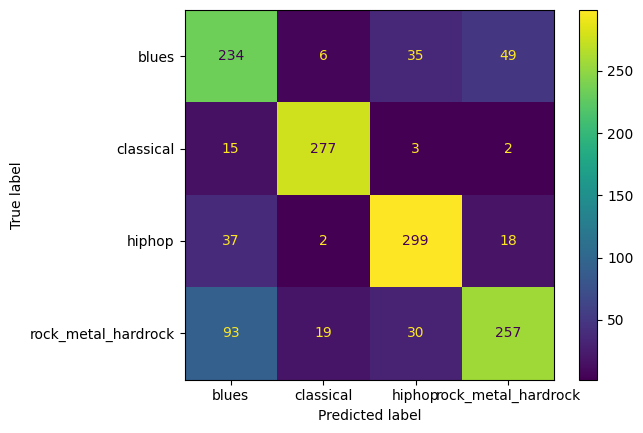

In [ ]:
#set_seed(SEED)
#model_conv_batchnorm = ConvolutionalNet_with_pooling_padding(activation).to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, model_conv_batchnorm , "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,loss_function)

**Ultimately, it appears that the above technique results in an increase in f1 and accuracy values, but also in a fairly significant difference between train and validation loss. Therefore, it does not particularly contribute to improving the classifier's performance. For this reason, it will not be used in the following steps.**

**Step 5: Normalization**

**The main purpose of using regularization techniques is to reduce the difference between train loss and validation loss. In this context, the following value tests are performed for both 30 and 60 epochs: (i) weight_decay in the optimizer and (ii) dropout in the linear layers. Tests are also performed on i) and ii) both separately and together.**

ConvolutionalNet_with_pooling_padding(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=32, bias=True)
  (dense5): Linear(in_features=32, out_features=4, bias=True)
  (activation): ELU(alpha=1.0)
)
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 1.8000e-03.
Epoch   0: Train Loss = 1.35831
Epoch   0: Valid Loss = 1.13534
Ep

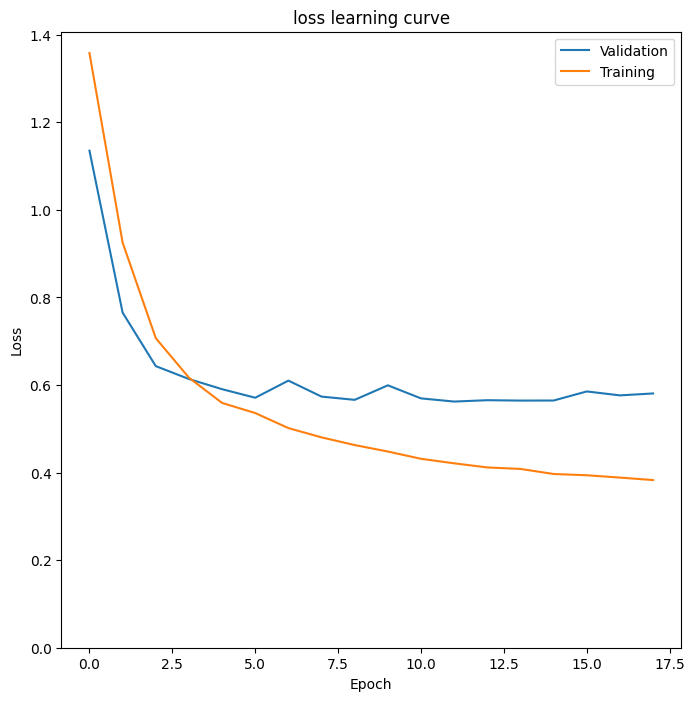

In [ ]:
activation = nn.ELU()
#dropout_probability = 0.25
set_seed(SEED)
model_conv_pooling_padding_act_reg = ConvolutionalNet_with_pooling_padding(activation).to(device)
print(model_conv_pooling_padding_act_reg)
#Change model.weights to the same type of training features.
#target_dtype = torch.float64
#for param in model_conv_pooling_padding_act_reg.parameters():
  #param.data = param.data.to(target_dtype)
#Initialized optimizer object
optimizer = Adagrad(model_conv_pooling_padding_act_reg.parameters(), lr=2e-3, weight_decay = 5e-5)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9, verbose = True)
cnn_pooling_padding_act= train_function(30, train_dataloader_mel, optimizer, loss_function, model_conv_pooling_padding_act_reg ,scheduler, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,validation_dataloader_mel)

Valid Loss = 0.58551
Valid f1_score = 0.78446
Valid Acurracy = 0.77907


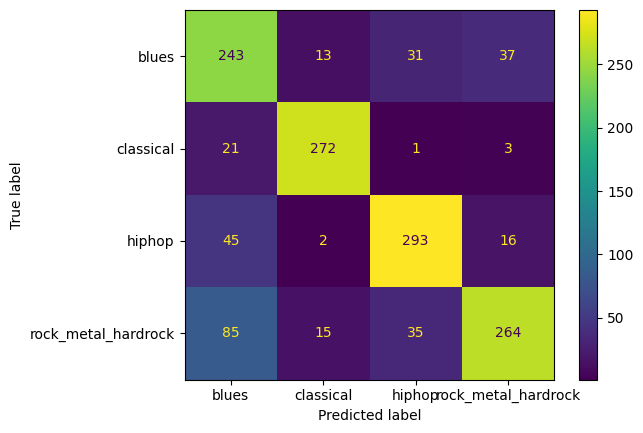

In [ ]:
#set_seed(SEED)
#model_conv_pooling_padding_act_reg = ConvolutionalNet_with_pooling_padding(activation).to(device)
test_loss_mel, test_f1_mel, test_accuracy_mel, confusion_matrix = test_function(test_dataloader_mel, model_conv_pooling_padding_act_reg , "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt" ,loss_function)

**Results of the above normalization techniques for 30 and 60 epochs, with dropout rate = 0.25 and weight_decay = 5e-5**

|           | dropout(30 epochs) | weight decay(30 epochs) | dropout(60 epochs)| weight decay(60 epochs)| dropout + weight decay(60 epochs)|
|-----------|-------|-------|----------|-------|-------|
| Accuracy  |0.77907|0.77907|  0.77907  |0.77471|0.77180|
| f1-score  |0.78286|0.78446|  0.78286 |0.78446|0.77507|


**It can be observed that the most blurred difference between train and validation loss, which also implies the best performance in terms of f1 and accuracy values, is for 30 epochs using weight decay = 5e-5. For each method (dropout, weight decay), it is observed that for 60 epochs the model has already learned the data. More specifically, it is observed that each model has learned the data in fewer than 30 epochs, and thus:**
1.   **Almost the same difference is observed between the train and validation loss for each model (which includes: optimizer: adagrad, activation function: ELU, learning rate scheduler: ExponentialLR, application of batch normalization technique, and also one of the following: dropout with dropout probability = 0.25 and weight decay = 5e-5).**
2.   **The performance of each model (f1, accuracy values) remains almost the same as in the 30 epochs.**




###**Step 7: Training efficiency**


**Batch size**

**One training variable that can affect the final performance of the model, as well as the training time, is the batch size.**

**Testing batch sizes of the first 7 powers of 2, and using the model that has yielded the best results so far (with optimizer adagrad, activation function softplus, learning rate scheduler, dropout rate= 0.05, and weight decay = 5e-3), the results in terms of performance and execution time are presented below.**

|           | batch size = 2 | batch size = 4 | batch size = 8| batch size = 16| batch size = 32|batch size = 64|batch size = 128|
|-----------|-------|-------|----------|-------|-------|-------|-------|
| Accuracy  |0.77326|0.77471|0.76526|0.77907|0.76744|0.77035|0.72892|
| f1-score  |0.77889|0.78208|0.76891|0.78446|0.77277|0.77441|0.72891|
| time running (seconds)  |202.26|105.16|53.78|28.55|17.73|14.99|12.28|

**Ultimately, it is clear that as the batch size decreases, the execution time increases. The dataloader for the best model, which includes optimizer: adagrad, activation function: ELU, learning rate scheduler: ExponentialLR, application of batch normalization technique and application of weight decay = 5e-5,  must be loaded with batch size = 16, because it gives better f1 and accuracy values, where the execution time will be reduced and because the difference between train and validation loss will be significantly reduced.**

###**Early Stopping**

**During the experiments conducted for this exercise, it was frequently observed that the best snapshot of the model was achieved well before the specified number of epochs. Therefore, continuing training until the final number of epochs is reached makes the process more time-consuming and also wastes resources.**

**For this reason, the number of epochs we set should be considered as the "maximum number of epochs." Therefore, the Early Stopping technique will be applied, which is a condition for terminating training if the performance (the f1 value, for example) of the model in the validation set for a consecutive (patience) number of epochs (e.g., 7) does not improve.**

**Below are the results for different values of patience, using the best performing model mentioned in the previous question.**

|           | patience = 4 | patience = 6| patience = 8|patience = 10|
|-----------|-------|-------|----------|-------|
| Accuracy  |0.77398| 0.77907 |0.77907|0.77907|
| f1-score  |0.77996| 0.78446|0.78446|0.78446|
| time running (seconds)  |12.40|17.99|19.30|24.28|

**Ultimately, it appears that the optimal number of consecutive seasons in which the performance of the validation set at value f1 does not improve (patience) and gives a better f1 value and accuracy is 6. As the value of patience increases, so does the execution time. It is observed that for patience values smaller than 6, the model's performance, with a significant difference between train and validation loss, shows a slight decrease in the f1 and accuracy metrics, as the model is still learning the data in the first iterations. Whereas for patience values greater than 6, we are at 30 epochs of the model and the difference between train and validation loss is the same, or slightly increased, and the f1 and accuracy values decrease slightly, because the model has learned the data.**

**Finally, based on questions 2 and 3, the best model with the best snapshot that emerged includes:**

**1. 4 convolutional layers with kernel size = 5 and channel sequence 1,16,32,64,128**

**2. 5 linear layers with 1024, 256, 32, and 4 neurons as the final output.**

**3. Adagrad as the optimizer (optimization function)**

**4. ELU as activation function**

**5. ExponentialLR as learning rate scheduler**

**6. Weight decay = 5e-5**

**7. Patience = 6**






###**Question 4: Testing**

**This question evaluates the classifier created throughout the exercise in the test set in order to determine its ability to generalize to real-world data that has not been used in training. An example of such data is YouTube videos.**

###**Step 1: Inference**


**The following function takes a dataset (dataloader with shuffle=False) and a trained Convolutional Neural Network and returns a list with the predictions of the best model that has emerged from questions 2 and 3 of the exercise.**


In [ ]:
#Test function
def test_youtube_function(dataloader,model,model_dir, model_save_name,loss_function):
    batch_losses_test = []
    Y_Preds = []
    Y_batches = []
    if not os.path.exists(model_dir):
     os.makedirs(model_dir)
    model_save_path = os.path.join(model_dir, model_save_name)
    model.load_state_dict(torch.load(model_save_path))
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
          x = x.to(device)
          y = y.to(device)
          y_predict = model(x)
          val_loss = loss_function(y_predict, y)
          batch_losses_test.append(val_loss.item())
          Y = y.tolist()
          Y_preds = y_predict.tolist()
          Y_batches.append(Y)
          Y_Preds.append(Y_preds)
        Y_batches = np.concatenate(Y_batches)
        Y_Preds = np.concatenate(Y_Preds)
        Y_Preds = np.argmax(Y_Preds, axis = 1)
        Test_f1 = f1_score(Y_batches, Y_Preds, average='macro')
        Test_accuracy = accuracy_score(Y_batches, Y_Preds)
        Test_loss = sum(batch_losses_test)/len(dataloader)
        print(f"Valid Loss = {Test_loss:.5f}")
        print(f"Valid f1_score = {Test_f1:.5f}")
        print(f"Valid Acurracy = {Test_accuracy:.5f}")

    return Y_Preds


###**Step 2: Download music**

**In the cell below, the following sequence of commands installs yt-dlp (https://github.com/yt-dlp/yt-dlp) in Google Colab instead of youtube-dl, (set of commands provided by the speaker) due to difficulties (e.g., error with extracting the id) and poor results. Due to yt_dlp, the corresponding change was also made to the command in youtube.py (command = f'yt-dlp -x --audio-format wav --audio-quality 0 --output {filename}.wav --postprocessor-args "-ar 8000 -ac 1" ' + url + " --quiet"). Also, in the corresponding initial youtube.py function given by the exercise statement in the subprocesses download_youtube and youtube_to_melgram, changes were made because in both we now have the url and the folder name (filename) as arguments.**






In [ ]:
!sudo apt-get update
!sudo curl -L https://github.com/yt-dlp/yt-dlp/releases/latest/download/yt-dlp -o /usr/local/bin/yt-dlp
!sudo chmod a+rx /usr/local/bin/yt-dlp  # Make executable!
#!sudo apt-get update
#!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
#!sudo chmod a+rx /usr/local/bin/youtube-dl


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:4 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0   

**More specifically, the youtube.py file provided with the data contains functions which, given a YouTube URL, download the audio and calculate a sequence of mel spectrograms (one for each second). The youtube_to_melgram function saves the melgram sequence of a given URL to the melgrams.npy file. Use it with at least one URL from each music genre contained in our dataset.**

**Here are some examples:**

**• classical music:** https://www.youtube.com/watch?v=9E6b3swbnWg

**• pop:** https://www.youtube.com/watch?v=EDwb9jOVRtU

**• rock:** https://www.youtube.com/watch?v=OMaycNcPsHI

**• blues:** https://www.youtube.com/watch?v=l45f28PzfCI

**The following commands convert the youtube.py function into a Python module.**

In [ ]:
!python3 -m pip install -U yt-dlp
!yt-dlp -x --audio-format wav --audio-quality 0 --output How_Blue_Can_You_Get.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=l45f28PzfCI --quiet
!yt-dlp -x --audio-format wav --audio-quality 0 --output Hung_Up.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=EDwb9jOVRtU --quiet
!yt-dlp -x --audio-format wav --audio-quality 0 --output  Every_You_Every_Me.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=OMaycNcPsHI --quiet
!yt-dlp -x --audio-format wav --audio-quality 0 --output Nocturne_op.9_No.2.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=9E6b3swbnWg --quiet

In [ ]:
!cp /content/drive/MyDrive/youtube.py /content

In [ ]:
import youtube
from youtube import youtube_to_melgram,download_youtube,get_melgrams

#def download_youtube(url,filename):
  #command = f'yt-dlp -x --audio-format wav --audio-quality 0 --output {filename}.wav --postprocessor-args "-ar 8000 -ac 1" ' + url + " --quiet"

  #os.system(command)

#def youtube_to_melgram(url, filename):
    #download_youtube(url, filename)
    #melgrams = get_melgrams(filename + ".wav")
    # np.save("youtube_melgrams.npy", melgrams)
    #return np.stack(melgrams)

In [ ]:
youtube_to_melgram_urls = []

features_blues = youtube_to_melgram("https://www.youtube.com/watch?v=l45f28PzfCI" , "How_Blue_Can_You_Get")
youtube_to_melgram_urls.append(features_blues)
features_classic_music= youtube_to_melgram("https://www.youtube.com/watch?v=9E6b3swbnWg" , "Nocturne_op.9_No.2")
youtube_to_melgram_urls.append(features_classic_music)
features_hiphop = youtube_to_melgram("https://www.youtube.com/watch?v=EDwb9jOVRtU" , "Hung_Up")
youtube_to_melgram_urls.append(features_hiphop)
features_rock_metal = youtube_to_melgram("https://www.youtube.com/watch?v=OMaycNcPsHI" , "Every_You_Every_Me")
youtube_to_melgram_urls.append(features_rock_metal)

In [ ]:
print(features_hiphop.shape,features_rock_metal.shape,features_blues.shape,features_classic_music.shape)

(334, 21, 128) (216, 21, 128) (313, 21, 128) (270, 21, 128)


Valid Loss = 1.20414
Valid f1_score = 0.17531
Valid Acurracy = 0.53994
Blues: 169 Classical: 15 Hip-hop: 55 Rock_metal_hardrock: 74 



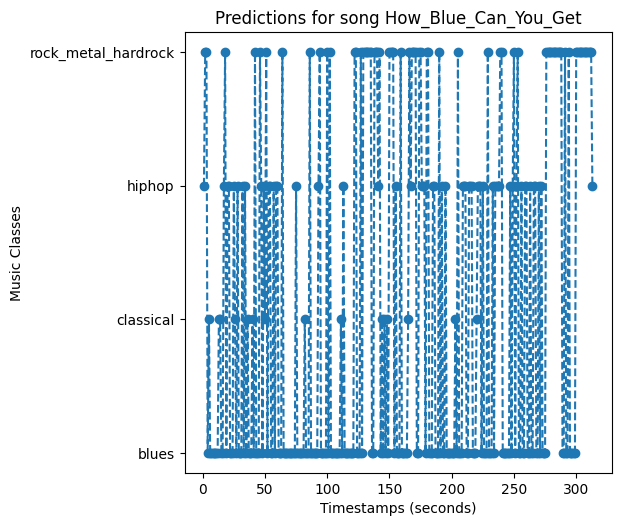

Valid Loss = 0.03086
Valid f1_score = 0.33147
Valid Acurracy = 0.98889
Blues: 2 Classical: 267 Hip-hop: 1 Rock_metal_hardrock: 0 



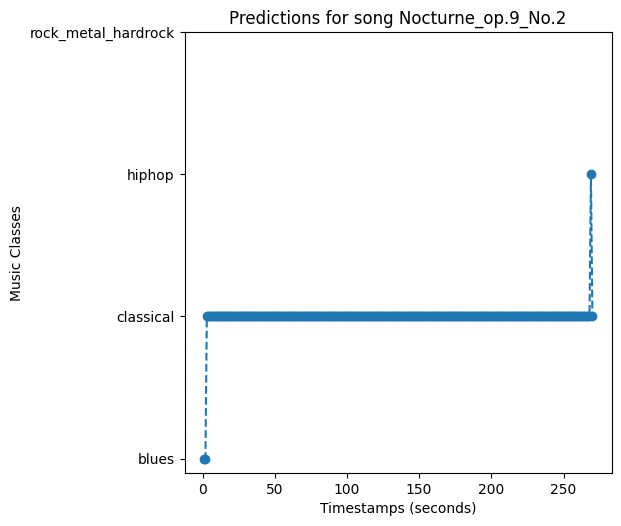

Valid Loss = 1.26792
Valid f1_score = 0.16331
Valid Acurracy = 0.48503
Blues: 54 Classical: 17 Hip-hop: 101 Rock_metal_hardrock: 162 



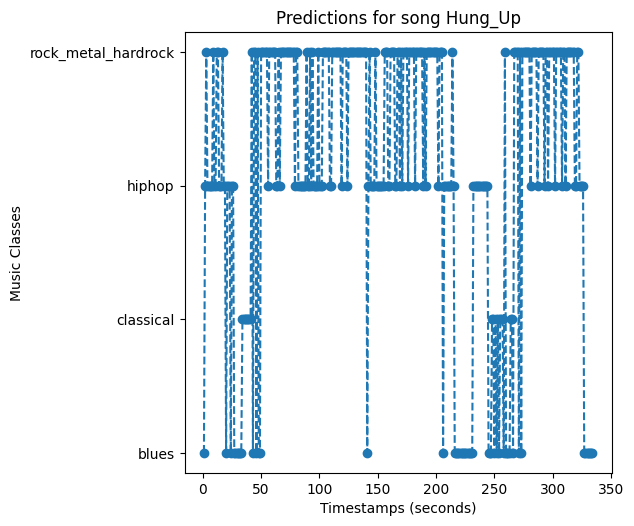

Valid Loss = 0.39620
Valid f1_score = 0.23850
Valid Acurracy = 0.91204
Blues: 10 Classical: 6 Hip-hop: 3 Rock_metal_hardrock: 197 



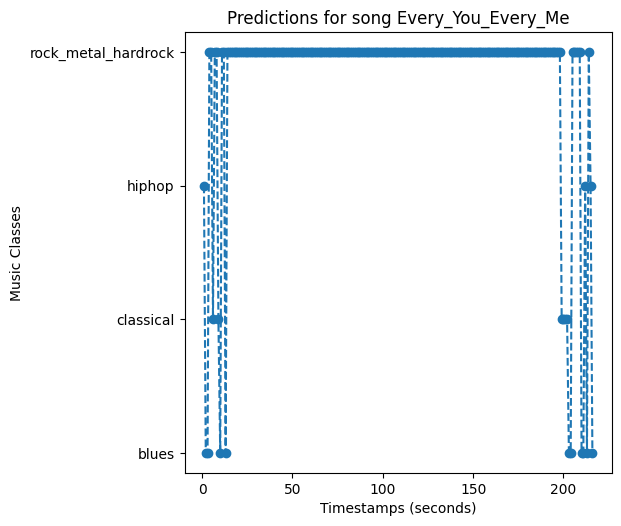

In [ ]:
def create_dataloader(x_test_mel,y_test_mel):

 test_data = TensorDataset(torch.from_numpy(x_test_mel), torch.from_numpy(y_test_mel))

 test_dataloader = DataLoader(test_data, batch_size=16, shuffle= False, num_workers=0,
    worker_init_fn=seed_worker)
 return test_dataloader
def correct_labels(predict_labels):
  blues = 0
  classical = 0
  hiphop = 0
  rock = 0
  for k in range(len(predict_labels)):
    if music_predict_labels[k] == 0:
      blues += 1
    elif predict_labels[k] == 1:
      classical += 1
    elif predict_labels[k] == 2:
      hiphop += 1
    else:
      rock += 1
  return blues,classical,hiphop,rock


activation = nn.ELU()
song_titles = ['How_Blue_Can_You_Get', 'Nocturne_op.9_No.2', 'Hung_Up', 'Every_You_Every_Me']


for i in range(len(song_titles)):
  fig, ax = plt.subplots(1, 1, figsize=(5,5))
  fig.tight_layout()
  if song_titles[i] == 'How_Blue_Can_You_Get':
    test_dataloader = create_dataloader(youtube_to_melgram_urls[i], np.zeros(youtube_to_melgram_urls[i].shape[0], dtype=np.int64))
  elif song_titles[i] == "Nocturne_op.9_No.2":
    test_dataloader = create_dataloader(youtube_to_melgram_urls[i], np.ones(youtube_to_melgram_urls[i].shape[0], dtype=np.int64))
  elif song_titles[i] == "Hung_up":
    test_dataloader = create_dataloader(youtube_to_melgram_urls[i], np.full(youtube_to_melgram_urls[i].shape[0], 2, dtype=np.int64))
  else:
    test_dataloader = create_dataloader(youtube_to_melgram_urls[i], np.full(youtube_to_melgram_urls[i].shape[0], 3, dtype=np.int64))
  set_seed(SEED)
  cnn_pooling_padding_act_reg = ConvolutionalNet_with_pooling_padding(activation).to(device)
  music_predict_labels = test_youtube_function(test_dataloader, cnn_pooling_padding_act_reg, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt", loss_function)

  #Count how many predictions we have for each music category in each list of predicted labels of each song
  blues,classical,hiphop,rock = correct_labels(music_predict_labels)
  print("Blues:", blues, "Classical:", classical, "Hip-hop:", hiphop, "Rock_metal_hardrock:", rock,"\n")
  timestamp_seconds = list(range(1,len(music_predict_labels)+1))
  ax.plot(timestamp_seconds, music_predict_labels, '--o')
  plt.xlabel('Timestamps (seconds)')
  plt.ylabel('Music Classes')
  plt.yticks(np.arange(0, len(label_encoder_mel.classes_)), list(label_encoder_mel.classes_))
  plt.title(f'Predictions for song {song_titles[i]}')
  plt.show()



/bin/bash: --quiet: command not found
[youtube] Extracting URL: https://www.youtube.com/watch?v=jlHEdkL1VoM
[youtube] jlHEdkL1VoM: Downloading webpage
[youtube] jlHEdkL1VoM: Downloading ios player API JSON
[youtube] jlHEdkL1VoM: Downloading android player API JSON
[youtube] jlHEdkL1VoM: Downloading m3u8 information
[info] jlHEdkL1VoM: Downloading 1 format(s): 251
[download] Smoke_on_the_Water.wav has already been downloaded
[ExtractAudio] Destination: Smoke_on_the_Water.wav
Deleting original file Smoke_on_the_Water.orig.wav (pass -k to keep)
Valid Loss = 0.28323
Valid f1_score = 0.23818
Valid Acurracy = 0.90972
Blues: 27 Classical: 7 Hip-hop: 5 Rock_metal_hardrock: 393 



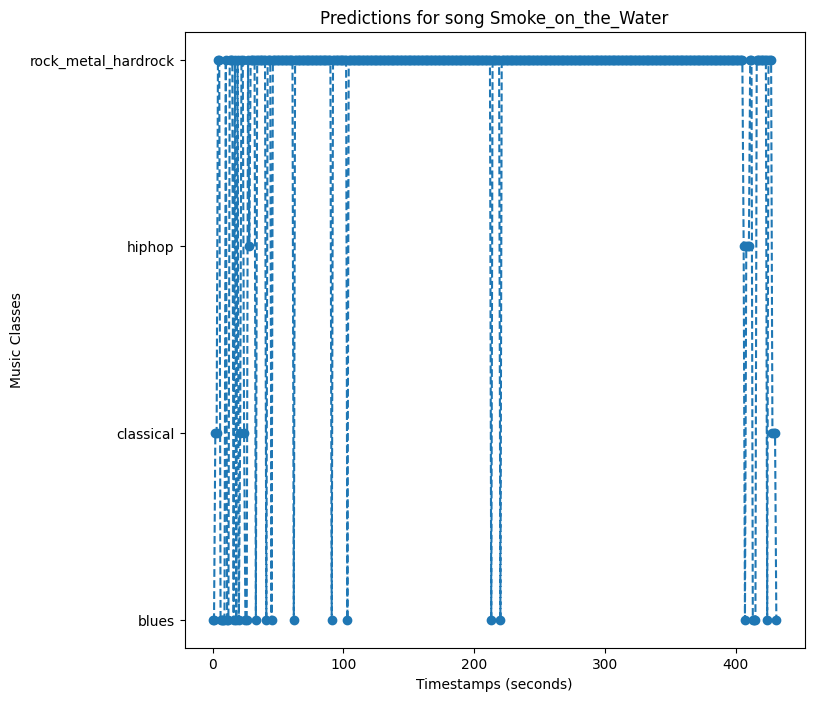

In [ ]:
!yt-dlp -x --audio-format wav --audio-quality 0 --output Smoke_on_the_Water.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=jlHEdkL1VoM&t=356s --quiet
features_rock_metal = youtube_to_melgram("https://www.youtube.com/watch?v=jlHEdkL1VoM&t=356s" , "Smoke_on_the_Water")
song_titles.append("Smoke_on_the_Water")
set_seed(SEED)
cnn_pooling_padding_act_reg = ConvolutionalNet_with_pooling_padding(activation).to(device)
test_dataloader = create_dataloader(features_rock_metal, np.full(features_rock_metal.shape[0], 3, dtype=np.int64))
music_predict_labels = test_youtube_function(test_dataloader, cnn_pooling_padding_act_reg, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt", loss_function)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
#Count how many predictions we have for each music category in each list of predicted labels of each song
blues,classical,hiphop,rock = correct_labels(music_predict_labels)
print("Blues:", blues, "Classical:", classical, "Hip-hop:", hiphop, "Rock_metal_hardrock:", rock,"\n")
timestamp_seconds = list(range(0,len(music_predict_labels)))
ax.plot(timestamp_seconds, music_predict_labels, '--o')
plt.xlabel('Timestamps (seconds)')
plt.ylabel('Music Classes')
plt.yticks(np.arange(0, len(label_encoder_mel.classes_)), list(label_encoder_mel.classes_))
plt.title(f'Predictions for song {song_titles[4]}')
plt.show()

Valid Loss = 0.40683
Valid f1_score = 0.23146
Valid Acurracy = 0.86190
Blues: 264 Classical: 2172 Hip-hop: 68 Rock_metal_hardrock: 16 



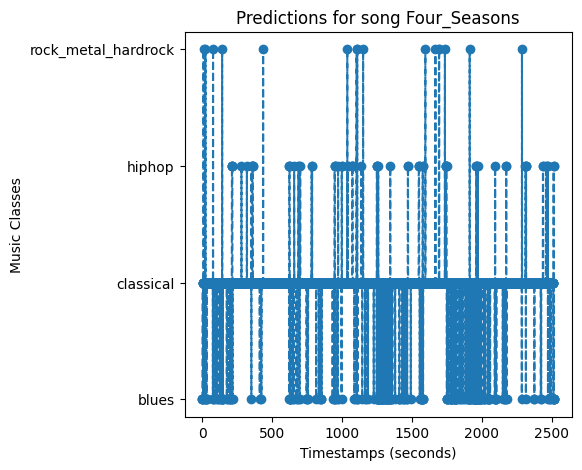

In [ ]:
!yt-dlp -x --audio-format wav --audio-quality 0 --output Four_Seasons.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=GRxofEmo3HA --quiet
features_classic = youtube_to_melgram("https://www.youtube.com/watch?v=GRxofEmo3HA" , "Four_Seasons")
test_dataloader = create_dataloader(features_classic, np.ones(features_classic.shape[0],dtype=np.int64))
song_titles.append('Four_Seasons')
set_seed(SEED)
cnn_pooling_padding_act_reg = ConvolutionalNet_with_pooling_padding(activation).to(device)
music_predict_labels = test_youtube_function(test_dataloader, cnn_pooling_padding_act_reg, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt", loss_function)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
#Count how many predictions we have for each music category in each list of predicted labels of each song
blues,classical,hiphop,rock = correct_labels(music_predict_labels)
print("Blues:", blues, "Classical:", classical, "Hip-hop:", hiphop, "Rock_metal_hardrock:", rock,"\n")
timestamp_seconds = list(range(0,len(music_predict_labels)))
ax.plot(timestamp_seconds, music_predict_labels, '--o')
plt.xlabel('Timestamps (seconds)')
plt.ylabel('Music Classes')
plt.yticks(np.arange(0, len(label_encoder_mel.classes_)), list(label_encoder_mel.classes_))
plt.title(f'Predictions for song {song_titles[5]}')
plt.show()



/bin/bash: --quiet: command not found
[youtube] Extracting URL: https://www.youtube.com/watch?v=hI8A14Qcv68
[youtube] hI8A14Qcv68: Downloading webpage
[youtube] hI8A14Qcv68: Downloading ios player API JSON
[youtube] hI8A14Qcv68: Downloading android player API JSON
[youtube] hI8A14Qcv68: Downloading m3u8 information
[info] hI8A14Qcv68: Downloading 1 format(s): 251
[download] N.Y._State_of_Mind.wav has already been downloaded
[ExtractAudio] Destination: N.Y._State_of_Mind.wav
Deleting original file N.Y._State_of_Mind.orig.wav (pass -k to keep)
Valid Loss = 0.76260
Valid f1_score = 0.20518
Valid Acurracy = 0.69595
Blues: 32 Classical: 1 Hip-hop: 206 Rock_metal_hardrock: 57 



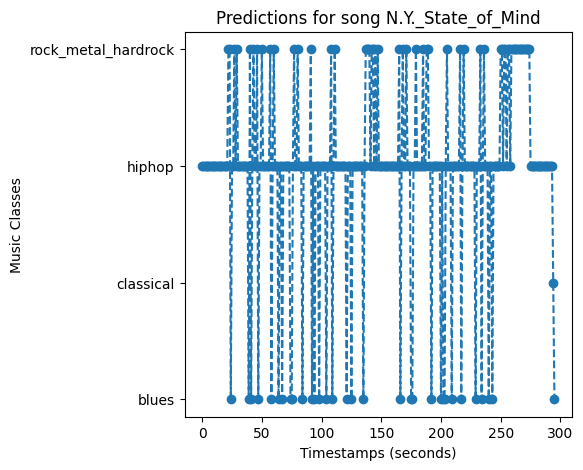

In [ ]:
!yt-dlp -x --audio-format wav --audio-quality 0 --output N.Y._State_of_Mind.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=hI8A14Qcv68&t=26s --quiet
features_hiphop = youtube_to_melgram("https://www.youtube.com/watch?v=hI8A14Qcv68&t=26s" , "N.Y._State_of_Mind")
song_titles.append('N.Y._State_of_Mind')
test_dataloader = create_dataloader(features_hiphop, np.full(features_hiphop.shape[0] , 2 ,dtype=np.int64))
set_seed(SEED)
cnn_pooling_padding_act_reg = ConvolutionalNet_with_pooling_padding(activation).to(device)
music_predict_labels = test_youtube_function(test_dataloader, cnn_pooling_padding_act_reg, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt", loss_function)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
#Count how many predictions we have for each music category in each list of predicted labels of each song
blues,classical,hiphop,rock = correct_labels(music_predict_labels)
print("Blues:", blues, "Classical:", classical, "Hip-hop:", hiphop, "Rock_metal_hardrock:", rock,"\n")
timestamp_seconds = list(range(0,len(music_predict_labels)))
ax.plot(timestamp_seconds, music_predict_labels, '--o')
plt.xlabel('Timestamps (seconds)')
plt.ylabel('Music Classes')
plt.yticks(np.arange(0, len(label_encoder_mel.classes_)), list(label_encoder_mel.classes_))
plt.title(f'Predictions for song {song_titles[6]}')
plt.show()

Valid Loss = 0.44635
Valid f1_score = 0.23232
Valid Acurracy = 0.86792
Blues: 138 Classical: 8 Hip-hop: 4 Rock_metal_hardrock: 9 



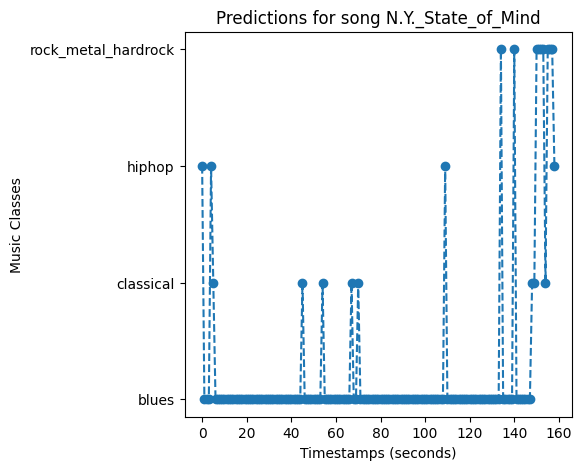

In [ ]:
!yt-dlp -x --audio-format wav --audio-quality 0 --output Im_Torn_Down.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=QJvpWZeg_NM --quiet
features_blues = youtube_to_melgram("https://www.youtube.com/watch?v=QJvpWZeg_NM" , "Im_Torn_Down")
song_titles.append('Im_Torn_Down')
test_dataloader = create_dataloader(features_blues, np.zeros(features_blues.shape[0] ,dtype=np.int64))
set_seed(SEED)
cnn_pooling_padding_act_reg = ConvolutionalNet_with_pooling_padding(activation).to(device)
music_predict_labels = test_youtube_function(test_dataloader, cnn_pooling_padding_act_reg, "drive/MyDrive/data/music_genre_data_di/","Best_Model.pt", loss_function)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
#Count how many predictions we have for each music category in each list of predicted labels of each song
blues,classical,hiphop,rock = correct_labels(music_predict_labels)
print("Blues:", blues, "Classical:", classical, "Hip-hop:", hiphop, "Rock_metal_hardrock:", rock,"\n")
timestamp_seconds = list(range(0,len(music_predict_labels)))
ax.plot(timestamp_seconds, music_predict_labels, '--o')
plt.xlabel('Timestamps (seconds)')
plt.ylabel('Music Classes')
plt.yticks(np.arange(0, len(label_encoder_mel.classes_)), list(label_encoder_mel.classes_))
plt.title(f'Predictions for song {song_titles[7]}')
plt.show()


**From all of the above 8 songs (at least one for each music genre we have), it can be seen that the classifier performs quite well, because it can correctly identify all 4 music classes, because in these music classes, the number of correct categorizations for each class is the highest possible out of all the other incorrect categorizations in the other music classes. Based on the logic described above, the 'hiphop' category has, on average (as a percentage), the fewest correct predictions compared to all other music genres.**

**In this classifier, we have categorization with accuracy close to or above 50% (e.g., blues, hiphop), which, since we have 4 classes for categorization, is a good percentage of correct predictions. There are also classes with accuracy close to or above 90%, which means that the corresponding music genres are found with great success (e.g. classical, rock_metal_hardrock). Thus, we can say that the classifier generalizes quite well with an accuracy that is very close to 77.907% (78%), which is the accuracy resulting from the test set.**

